# Clear Street Markets Quantitative Researcher Take Home Project

              Author: Bob Pied Cowboy | Date: December 3, 2023 | Email: bobpiedcowboy@proton.me

# Data

Hostname: xyz | Username: xyz | Password: xyz

# Computer Specifications

Laptop: Intel(R) Core(TM) i5-4210M CPU @ 2.60GHz 2.59 GHz, RAM: 12.0 GB and system type: Windows 64-bit operating system, x64-based processor. 

# Goal

Find a model to calibrate 2 subsets of dependent variables, Y1 and Y2, in relationship to independent variables X1 to X375
while considering quality variables Q1 and Q2 covering the 15-month period 20220104 - 20230331.

N.B. ⇒ Use only 1 of the 3 techniques:  Linear regression, gradient-boosted trees, or neural networks.

# Challenges

- Massive dataset (metadata) consumes memory and time
-Curse of dimensionality
- Time series where patterns can be hidden in high frequency trading
- Many independent variables X1 to X375 with potential autocorrelation
- Model sensitive to in-sample and out-of-sample
- Calibration subject to feature selection used

# Data Cleaning

In [1]:
#load packages
from pathlib import Path #to manipulate paths 
import pandas as pd #to examine dataframe
import glob # to concatenante all parquet files
import os #operating system dependent functionality to manipulate paths
import matplotlib.pyplot as plt #for visual graphs
import seaborn as sns # for heat map
import time #computational system 
import random #for seed

#for models
import numpy as np #for numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, SequentialFeatureSelector
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
import itertools
from itertools import product  

# Examine 1 parquet

In [2]:
#examine firt parquet file
df1 = pd.read_parquet('capital//QR_TAKEHOME_20220103.csv.parquet', engine='auto')
display(df1)
print(df1.count())

,time,sym,exch,Q1,Q2,X1,X10,X100,X101,X102,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
0,35101000,SPX,cme,1.0,1.00,-1.985130,-0.440099,0.044736,-0.010772,-0.453612,...,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752,-49.671906,-61.707756
1,35102000,SPX,cme,1.0,1.00,-0.933646,-0.380986,-0.854499,-0.951011,-0.622912,...,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521,-48.895279,-62.025402
2,35103000,SPX,cme,1.0,1.00,-0.579249,-0.180915,-0.854372,-0.969687,-0.320432,...,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525,-47.067436,-57.324017
3,35104000,SPX,cme,1.0,1.00,-0.658292,-0.028344,-0.044026,-0.496256,-0.057465,...,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654,-47.590408,-58.769417
4,35105000,SPX,cme,1.0,1.00,-1.331419,-0.100419,0.273158,0.218558,0.373589,...,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009,-48.110863,-59.984489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,57596000,SPX,cme,1.0,0.12,0.691885,-0.042504,NaN,-0.702264,-1.332660,...,-1.382789,-0.638166,-1.212015,NaN,-1.251485,-1.108500,-1.051484,-0.919427,2.089700,2.729775
22496,57597000,SPX,cme,1.0,0.12,0.765635,0.173535,NaN,-0.118226,-0.134356,...,-0.181235,0.038323,-0.556775,NaN,-0.669952,0.086631,-0.373499,-0.258363,0.522343,1.137225
22497,57598000,SPX,cme,1.0,0.12,0.374935,-0.306421,NaN,-0.344100,-1.051101,...,-1.084311,-0.728195,-1.180938,NaN,-0.903521,-0.854355,-1.165247,-0.862813,2.612262,3.184882
22498,57599000,SPX,cme,1.0,0.12,1.705910,0.796923,NaN,0.076075,0.244281,...,0.209397,1.118176,0.571770,NaN,-0.481382,0.446565,0.720278,0.869785,0.000000,0.985580


time    22500
sym     22500
exch    22500
Q1      22500
Q2      22500
        ...  
X97     22407
X98     22481
X99     22491
Y1      22500
Y2      22500
Length: 382, dtype: int64


# Parquet Selection

Each parquet file is approximately 35 MG which is memory consuming. We downloaded from FTP the 298 parquet files on my laptop and
it consumed 10 GB which is a significant capacity and slowed down the computer. The project aims to examine metadata without
assistance from various massive cloud networks such as Azure and AWS to merge the parquet file. After spending 2 full days 
attempting various samples to group parquet file in big groups, we opted to use 100 files from 20220103 to 20220602 as
in-sample group and the remaining files from 20220606 to 20221031 as out-of-sample group. The files from 20221101 to 
202030331 have not been used in the project.The concatenation of the total 298 files took time and leaded to 
a .csv file of 23.3 GB which was too big and too slow to analyze. We then opted to concatenante 230 files which produced
a .csv file of 17.9 GB which was also too big and too slow to analyze. Consequently, we then concatenated 100 files equal to 7.8 GB to obtain an in-sample dataset. We did the same to obtain an out-of-sample dataset. However, there was not enough memory capacity to run 2 massive datasets at the same to forecast y_test out-sample with x_train in-sample. Consequently, we created
a new out-sample concatenated parquet selection leading to a 700 MB .csv file composed of 10 parquet files from 20220606 to 20220617. 

# Technical remark

We have worked several days on the project. Consequently, there are many additions to sections and subsections. 
We articulate the additions and provide details. The jupyter notebook remains fluid even with additions to ensure
that results can be replicated.

# 1. In-sample Analysis

In [3]:
#examine names of all parquet files in directory
path_dir = 'C://Users//CanBec//Desktop//qr_takehome'
for files in os.listdir(path_dir):
    print(files)
   

arrow.pdf
Clear_Street_Markets_-_Take_Home_Project.docx!.pdf
QR_TAKEHOME_20220103.csv.parquet
QR_TAKEHOME_20220104.csv.parquet
QR_TAKEHOME_20220105.csv.parquet
QR_TAKEHOME_20220106.csv.parquet
QR_TAKEHOME_20220107.csv.parquet
QR_TAKEHOME_20220110.csv.parquet
QR_TAKEHOME_20220111.csv.parquet
QR_TAKEHOME_20220112.csv.parquet
QR_TAKEHOME_20220113.csv.parquet
QR_TAKEHOME_20220114.csv.parquet
QR_TAKEHOME_20220118.csv.parquet
QR_TAKEHOME_20220119.csv.parquet
QR_TAKEHOME_20220120.csv.parquet
QR_TAKEHOME_20220121.csv.parquet
QR_TAKEHOME_20220124.csv.parquet
QR_TAKEHOME_20220125.csv.parquet
QR_TAKEHOME_20220126.csv.parquet
QR_TAKEHOME_20220127.csv.parquet
QR_TAKEHOME_20220131.csv.parquet
QR_TAKEHOME_20220201.csv.parquet
QR_TAKEHOME_20220202.csv.parquet
QR_TAKEHOME_20220203.csv.parquet
QR_TAKEHOME_20220204.csv.parquet
QR_TAKEHOME_20220207.csv.parquet
QR_TAKEHOME_20220208.csv.parquet
QR_TAKEHOME_20220209.csv.parquet
QR_TAKEHOME_20220210.csv.parquet
QR_TAKEHOME_20220211.csv.parquet
QR_TAKEHOME_202

# Metadata Concatenation

In [97]:
#concatenante all parquet files into 1 csv file
data_dir = Path('C://Users//CanBec//Desktop//qr_takehome')
for i, parquet_path in enumerate(data_dir.glob('*.parquet')):
    df = pd.read_parquet(parquet_path)
    write_header = i == 0 # write header only on the 0th file
    write_mode = 'w' if i == 0 else 'a' # 'write' mode for 0th file, 'append' otherwise
    df.to_csv('csv_file.csv', mode=write_mode, header=write_header)

In [4]:
# get the start time
st = time.process_time()

#rename concatenated csv file into new dataframe
FinalDF = pd.read_csv('csv_file.csv')
print(FinalDF.count())

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

Unnamed: 0    2250000
time          2250000
sym           2250000
exch          2250000
Q1            2250000
               ...   
X97           2145108
X98           2160854
X99           2245763
Y1            2250000
Y2            2250000
Length: 383, dtype: int64
Execution time: 3.065625 minutes


In [3]:
#technical information about dataframe
FinalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250000 entries, 0 to 2249999
Columns: 383 entries, Unnamed: 0 to Y2
dtypes: float64(379), int64(2), object(2)
memory usage: 6.4+ GB


In [4]:
#Analyzing memory print for attributes
FinalDF.memory_usage(deep=True) 

Index               128
Unnamed: 0     18000000
time           18000000
sym           135000000
exch          135000000
                ...    
X97            18000000
X98            18000000
X99            18000000
Y1             18000000
Y2             18000000
Length: 384, dtype: int64

# Optimize memory use

To boost memory capacity and speed up execution, we downcast variables.

In [5]:
# get the start time
st = time.process_time()

#downcast to limit memory consumption for approx half the variables
#sym and exch not downcasted
FinalDF["time"] = pd.to_numeric(FinalDF["time"], downcast="integer")
FinalDF["Q1"] = pd.to_numeric(FinalDF["Q1"], downcast="integer")
FinalDF["Q2"] = pd.to_numeric(FinalDF["Q2"], downcast="integer")
FinalDF["X1"] = pd.to_numeric(FinalDF["X1"], downcast="integer")
FinalDF["X2"] = pd.to_numeric(FinalDF["X2"], downcast="integer")
FinalDF["X3"] = pd.to_numeric(FinalDF["X3"], downcast="integer")
FinalDF["X4"] = pd.to_numeric(FinalDF["X4"], downcast="integer")
FinalDF["X5"] = pd.to_numeric(FinalDF["X5"], downcast="integer")
FinalDF["X6"] = pd.to_numeric(FinalDF["X6"], downcast="integer")
FinalDF["X7"] = pd.to_numeric(FinalDF["X7"], downcast="integer")
FinalDF["X8"] = pd.to_numeric(FinalDF["X8"], downcast="integer")
FinalDF["X9"] = pd.to_numeric(FinalDF["X9"], downcast="integer")
FinalDF["X10"] = pd.to_numeric(FinalDF["X10"], downcast="integer")
FinalDF["X20"] = pd.to_numeric(FinalDF["X20"], downcast="integer")
FinalDF["X21"] = pd.to_numeric(FinalDF["X21"], downcast="integer")
FinalDF["X22"] = pd.to_numeric(FinalDF["X22"], downcast="integer")
FinalDF["X23"] = pd.to_numeric(FinalDF["X23"], downcast="integer")
FinalDF["X24"] = pd.to_numeric(FinalDF["X24"], downcast="integer")
FinalDF["X25"] = pd.to_numeric(FinalDF["X25"], downcast="integer")
FinalDF["X26"] = pd.to_numeric(FinalDF["X26"], downcast="integer")
FinalDF["X27"] = pd.to_numeric(FinalDF["X27"], downcast="integer")
FinalDF["X28"] = pd.to_numeric(FinalDF["X28"], downcast="integer")
FinalDF["X29"] = pd.to_numeric(FinalDF["X29"], downcast="integer")
FinalDF["X50"] = pd.to_numeric(FinalDF["X50"], downcast="integer")
FinalDF["X51"] = pd.to_numeric(FinalDF["X51"], downcast="integer")
FinalDF["X52"] = pd.to_numeric(FinalDF["X52"], downcast="integer")
FinalDF["X53"] = pd.to_numeric(FinalDF["X53"], downcast="integer")
FinalDF["X54"] = pd.to_numeric(FinalDF["X54"], downcast="integer")
FinalDF["X55"] = pd.to_numeric(FinalDF["X55"], downcast="integer")
FinalDF["X56"] = pd.to_numeric(FinalDF["X56"], downcast="integer")
FinalDF["X57"] = pd.to_numeric(FinalDF["X57"], downcast="integer")
FinalDF["X58"] = pd.to_numeric(FinalDF["X58"], downcast="integer")
FinalDF["X59"] = pd.to_numeric(FinalDF["X59"], downcast="integer")
FinalDF["X80"] = pd.to_numeric(FinalDF["X80"], downcast="integer")
FinalDF["X81"] = pd.to_numeric(FinalDF["X81"], downcast="integer")
FinalDF["X82"] = pd.to_numeric(FinalDF["X82"], downcast="integer")
FinalDF["X83"] = pd.to_numeric(FinalDF["X83"], downcast="integer")
FinalDF["X84"] = pd.to_numeric(FinalDF["X84"], downcast="integer")
FinalDF["X85"] = pd.to_numeric(FinalDF["X85"], downcast="integer")
FinalDF["X86"] = pd.to_numeric(FinalDF["X86"], downcast="integer")
FinalDF["X87"] = pd.to_numeric(FinalDF["X87"], downcast="integer")
FinalDF["X88"] = pd.to_numeric(FinalDF["X88"], downcast="integer")
FinalDF["X89"] = pd.to_numeric(FinalDF["X89"], downcast="integer")
FinalDF["X110"] = pd.to_numeric(FinalDF["X110"], downcast="integer")
FinalDF["X111"] = pd.to_numeric(FinalDF["X111"], downcast="integer")
FinalDF["X112"] = pd.to_numeric(FinalDF["X112"], downcast="integer")
FinalDF["X113"] = pd.to_numeric(FinalDF["X113"], downcast="integer")
FinalDF["X114"] = pd.to_numeric(FinalDF["X114"], downcast="integer")
FinalDF["X115"] = pd.to_numeric(FinalDF["X115"], downcast="integer")
FinalDF["X116"] = pd.to_numeric(FinalDF["X116"], downcast="integer")
FinalDF["X117"] = pd.to_numeric(FinalDF["X117"], downcast="integer")
FinalDF["X118"] = pd.to_numeric(FinalDF["X118"], downcast="integer")
FinalDF["X119"] = pd.to_numeric(FinalDF["X119"], downcast="integer")
FinalDF["X140"] = pd.to_numeric(FinalDF["X140"], downcast="integer")
FinalDF["X141"] = pd.to_numeric(FinalDF["X141"], downcast="integer")
FinalDF["X142"] = pd.to_numeric(FinalDF["X142"], downcast="integer")
FinalDF["X143"] = pd.to_numeric(FinalDF["X143"], downcast="integer")
FinalDF["X144"] = pd.to_numeric(FinalDF["X144"], downcast="integer")
FinalDF["X145"] = pd.to_numeric(FinalDF["X145"], downcast="integer")
FinalDF["X146"] = pd.to_numeric(FinalDF["X146"], downcast="integer")
FinalDF["X147"] = pd.to_numeric(FinalDF["X147"], downcast="integer")
FinalDF["X148"] = pd.to_numeric(FinalDF["X148"], downcast="integer")
FinalDF["X149"] = pd.to_numeric(FinalDF["X149"], downcast="integer")
FinalDF["X170"] = pd.to_numeric(FinalDF["X170"], downcast="integer")
FinalDF["X171"] = pd.to_numeric(FinalDF["X171"], downcast="integer")
FinalDF["X172"] = pd.to_numeric(FinalDF["X172"], downcast="integer")
FinalDF["X173"] = pd.to_numeric(FinalDF["X173"], downcast="integer")
FinalDF["X174"] = pd.to_numeric(FinalDF["X174"], downcast="integer")
FinalDF["X175"] = pd.to_numeric(FinalDF["X175"], downcast="integer")
FinalDF["X176"] = pd.to_numeric(FinalDF["X176"], downcast="integer")
FinalDF["X177"] = pd.to_numeric(FinalDF["X177"], downcast="integer")
FinalDF["X178"] = pd.to_numeric(FinalDF["X178"], downcast="integer")
FinalDF["X179"] = pd.to_numeric(FinalDF["X179"], downcast="integer")
FinalDF["X200"] = pd.to_numeric(FinalDF["X200"], downcast="integer")
FinalDF["X201"] = pd.to_numeric(FinalDF["X201"], downcast="integer")
FinalDF["X202"] = pd.to_numeric(FinalDF["X202"], downcast="integer")
FinalDF["X203"] = pd.to_numeric(FinalDF["X203"], downcast="integer")
FinalDF["X204"] = pd.to_numeric(FinalDF["X204"], downcast="integer")
FinalDF["X205"] = pd.to_numeric(FinalDF["X205"], downcast="integer")
FinalDF["X206"] = pd.to_numeric(FinalDF["X206"], downcast="integer")
FinalDF["X207"] = pd.to_numeric(FinalDF["X207"], downcast="integer")
FinalDF["X208"] = pd.to_numeric(FinalDF["X208"], downcast="integer")
FinalDF["X209"] = pd.to_numeric(FinalDF["X209"], downcast="integer")
FinalDF["X230"] = pd.to_numeric(FinalDF["X230"], downcast="integer")
FinalDF["X231"] = pd.to_numeric(FinalDF["X231"], downcast="integer")
FinalDF["X232"] = pd.to_numeric(FinalDF["X232"], downcast="integer")
FinalDF["X233"] = pd.to_numeric(FinalDF["X233"], downcast="integer")
FinalDF["X234"] = pd.to_numeric(FinalDF["X234"], downcast="integer")
FinalDF["X235"] = pd.to_numeric(FinalDF["X235"], downcast="integer")
FinalDF["X236"] = pd.to_numeric(FinalDF["X236"], downcast="integer")
FinalDF["X237"] = pd.to_numeric(FinalDF["X237"], downcast="integer")
FinalDF["X238"] = pd.to_numeric(FinalDF["X238"], downcast="integer")
FinalDF["X239"] = pd.to_numeric(FinalDF["X239"], downcast="integer")
FinalDF["X260"] = pd.to_numeric(FinalDF["X260"], downcast="integer")
FinalDF["X261"] = pd.to_numeric(FinalDF["X261"], downcast="integer")
FinalDF["X262"] = pd.to_numeric(FinalDF["X262"], downcast="integer")
FinalDF["X263"] = pd.to_numeric(FinalDF["X263"], downcast="integer")
FinalDF["X264"] = pd.to_numeric(FinalDF["X264"], downcast="integer")
FinalDF["X265"] = pd.to_numeric(FinalDF["X265"], downcast="integer")
FinalDF["X266"] = pd.to_numeric(FinalDF["X266"], downcast="integer")
FinalDF["X267"] = pd.to_numeric(FinalDF["X267"], downcast="integer")
FinalDF["X268"] = pd.to_numeric(FinalDF["X268"], downcast="integer")
FinalDF["X269"] = pd.to_numeric(FinalDF["X269"], downcast="integer")
FinalDF["X280"] = pd.to_numeric(FinalDF["X280"], downcast="integer")
FinalDF["X281"] = pd.to_numeric(FinalDF["X281"], downcast="integer")
FinalDF["X282"] = pd.to_numeric(FinalDF["X282"], downcast="integer")
FinalDF["X283"] = pd.to_numeric(FinalDF["X283"], downcast="integer")
FinalDF["X284"] = pd.to_numeric(FinalDF["X284"], downcast="integer")
FinalDF["X285"] = pd.to_numeric(FinalDF["X285"], downcast="integer")
FinalDF["X286"] = pd.to_numeric(FinalDF["X286"], downcast="integer")
FinalDF["X287"] = pd.to_numeric(FinalDF["X287"], downcast="integer")
FinalDF["X288"] = pd.to_numeric(FinalDF["X288"], downcast="integer")
FinalDF["X289"] = pd.to_numeric(FinalDF["X289"], downcast="integer")
FinalDF["X310"] = pd.to_numeric(FinalDF["X310"], downcast="integer")
FinalDF["X311"] = pd.to_numeric(FinalDF["X311"], downcast="integer")
FinalDF["X312"] = pd.to_numeric(FinalDF["X312"], downcast="integer")
FinalDF["X313"] = pd.to_numeric(FinalDF["X313"], downcast="integer")
FinalDF["X314"] = pd.to_numeric(FinalDF["X314"], downcast="integer")
FinalDF["X315"] = pd.to_numeric(FinalDF["X315"], downcast="integer")
FinalDF["X316"] = pd.to_numeric(FinalDF["X316"], downcast="integer")
FinalDF["X317"] = pd.to_numeric(FinalDF["X317"], downcast="integer")
FinalDF["X318"] = pd.to_numeric(FinalDF["X318"], downcast="integer")
FinalDF["X319"] = pd.to_numeric(FinalDF["X319"], downcast="integer")
FinalDF["X320"] = pd.to_numeric(FinalDF["X320"], downcast="integer")
FinalDF["X321"] = pd.to_numeric(FinalDF["X321"], downcast="integer")
FinalDF["X322"] = pd.to_numeric(FinalDF["X322"], downcast="integer")
FinalDF["X323"] = pd.to_numeric(FinalDF["X323"], downcast="integer")
FinalDF["X324"] = pd.to_numeric(FinalDF["X324"], downcast="integer")
FinalDF["X325"] = pd.to_numeric(FinalDF["X325"], downcast="integer")
FinalDF["X326"] = pd.to_numeric(FinalDF["X326"], downcast="integer")
FinalDF["X327"] = pd.to_numeric(FinalDF["X327"], downcast="integer")
FinalDF["X328"] = pd.to_numeric(FinalDF["X328"], downcast="integer")
FinalDF["X329"] = pd.to_numeric(FinalDF["X329"], downcast="integer")
FinalDF["X340"] = pd.to_numeric(FinalDF["X340"], downcast="integer")
FinalDF["X341"] = pd.to_numeric(FinalDF["X341"], downcast="integer")
FinalDF["X342"] = pd.to_numeric(FinalDF["X342"], downcast="integer")
FinalDF["X343"] = pd.to_numeric(FinalDF["X343"], downcast="integer")
FinalDF["X344"] = pd.to_numeric(FinalDF["X344"], downcast="integer")
FinalDF["X345"] = pd.to_numeric(FinalDF["X345"], downcast="integer")
FinalDF["X346"] = pd.to_numeric(FinalDF["X346"], downcast="integer")
FinalDF["X347"] = pd.to_numeric(FinalDF["X347"], downcast="integer")
FinalDF["X348"] = pd.to_numeric(FinalDF["X348"], downcast="integer")
FinalDF["X349"] = pd.to_numeric(FinalDF["X349"], downcast="integer")
FinalDF["X360"] = pd.to_numeric(FinalDF["X360"], downcast="integer")
FinalDF["X361"] = pd.to_numeric(FinalDF["X361"], downcast="integer")
FinalDF["X362"] = pd.to_numeric(FinalDF["X362"], downcast="integer")
FinalDF["X363"] = pd.to_numeric(FinalDF["X363"], downcast="integer")
FinalDF["X364"] = pd.to_numeric(FinalDF["X364"], downcast="integer")
FinalDF["X365"] = pd.to_numeric(FinalDF["X365"], downcast="integer")
FinalDF["X366"] = pd.to_numeric(FinalDF["X366"], downcast="integer")
FinalDF["X367"] = pd.to_numeric(FinalDF["X367"], downcast="integer")
FinalDF["X368"] = pd.to_numeric(FinalDF["X368"], downcast="integer")
FinalDF["X369"] = pd.to_numeric(FinalDF["X369"], downcast="integer")
FinalDF["X370"] = pd.to_numeric(FinalDF["X370"], downcast="integer")
FinalDF["X371"] = pd.to_numeric(FinalDF["X371"], downcast="integer")
FinalDF["X372"] = pd.to_numeric(FinalDF["X372"], downcast="integer")
FinalDF["X373"] = pd.to_numeric(FinalDF["X373"], downcast="integer")

FinalDF.dtypes
FinalDF.memory_usage(deep=True) 



# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

Execution time: 17.946614583333332 minutes


# 1.1 Data Exploration

Execution time: 7.168489583333334 minutes


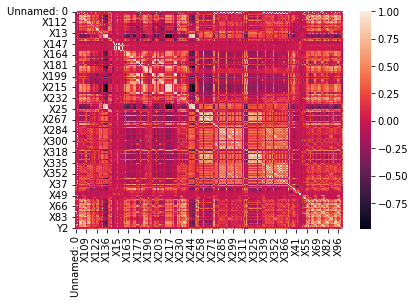

In [30]:
# get the start time
st = time.process_time()

#examine correlation heat map
sns.heatmap(FinalDF.corr())

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

The correlation heatmap  shows the covariance between some variables. The correlation matrix indicates that most 
variables have a correlation between -0.5 and 0.5. There are too many variables to underpin major dependent variables.

In [6]:
# get the start time
st = time.process_time()

#check for "999999" values
FinalDF[FinalDF.eq("999999").any(1)]
print(len(FinalDF[FinalDF.eq("999999").any(1)]))

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

0
Execution time: 0.6588541666666666 minutes


In [42]:
# Create a list to keep the number of variables detected that have values different from zero

nb_detected=[]
variable="X"

for x in range(1,375):
    current_variable=variable+str(x)
    print('current variable',current_variable)
    print('number of variables',FinalDF[FinalDF[current_variable]!=0].shape[0])
    nb_detected.append(FinalDF[FinalDF[current_variable]!=0].shape[0])

current variable X1
number of variables 2250000
current variable X2
number of variables 2250000
current variable X3
number of variables 2250000
current variable X4
number of variables 2250000
current variable X5
number of variables 2250000
current variable X6
number of variables 2250000
current variable X7
number of variables 2250000
current variable X8
number of variables 2250000
current variable X9
number of variables 2250000
current variable X10
number of variables 2250000
current variable X11
number of variables 2250000
current variable X12
number of variables 2250000
current variable X13
number of variables 2250000
current variable X14
number of variables 2250000
current variable X15
number of variables 2250000
current variable X16
number of variables 2250000
current variable X17
number of variables 2250000
current variable X18
number of variables 2250000
current variable X19
number of variables 2250000
current variable X20
number of variables 2250000
current variable X21
number o

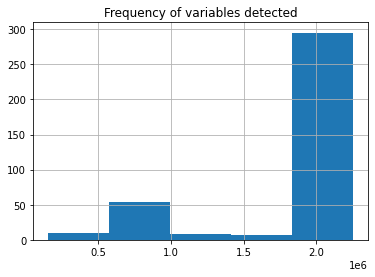

In [43]:
# Create histogram with number of variables detected
variable_df=pd.DataFrame(nb_detected,columns=["Frequency of variables detected"])
pd.DataFrame(nb_detected,columns=["Frequency of variables detected"]).hist(bins=5)
plt.show()

The figure shows the frequency of variables in the dataset. The histogram is uneven. We notice 2 distinct categories: 1) Approximately 50 variables are detected between 500 000 and 1 million times and 2) Approximately 300 variables are detected between 1 800 000 and 2 900 000 times.

In [7]:
#total length of dataframe in number of rows
FinalDF.shape[0]

2250000

There is a total of  2 250 000 rows in the dataset. We partition the dataset into 2 subsets to examine Y1 and Y2.
Each dataset, Y1 and Y2, has 1 125 000 rows. 

# Creation of 2 datasets for calibration

In [42]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)
print("Shape of new dataframes - {} , {}".format(df_Y1.shape, df_Y2.shape))
print(len(df_Y2))
print(len(df_Y1))

Shape of new dataframes - (1125000, 383) , (1125000, 383)
1125000
1125000


In [26]:
# find rows when Q1 < 0.9999 from df_Y1 for calibration
Remove_from_Y1 = df_Y1.loc[df_Y1["Q1"] < 0.9999]
display(Remove_from_Y1)
print(len(Remove_from_Y1))

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
877661,161,35262000,SPX,cme,0.15,1.00,-2.622088,NaN,1.603132,1.038186,...,NaN,NaN,-1.325610,2.580005,-1.077234,NaN,NaN,-0.900923,-10.101911,-23.150536
797281,9781,44882000,SPX,cme,0.15,1.00,0.061685,NaN,-0.022297,-0.137937,...,NaN,NaN,-0.386213,-0.412182,-0.539431,NaN,NaN,-0.173875,14.288980,12.525470
652160,22160,57261000,SPX,cme,0.12,1.00,-0.233593,0.355727,-0.183156,-0.026638,...,NaN,-0.329866,-0.265192,-0.383391,-0.082771,NaN,0.307844,-0.656939,2.241085,7.279766
1996404,16404,51505000,SPX,cme,0.15,1.00,-0.140026,NaN,0.589061,0.535891,...,NaN,NaN,0.449796,0.948975,0.743905,NaN,NaN,0.494652,-36.351315,-50.805763
1058609,1109,36210000,SPX,cme,0.15,1.00,2.102503,NaN,0.469402,0.153120,...,NaN,NaN,1.904822,2.929478,2.974037,NaN,NaN,0.711477,6.811409,15.345945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072148,2148,37249000,SPX,cme,0.15,1.00,1.176317,NaN,-0.158799,-0.259784,...,NaN,NaN,1.708218,-1.788569,-1.437797,NaN,NaN,0.721085,5.093757,-2.320993
832493,22493,57594000,SPX,cme,0.21,0.12,NaN,NaN,NaN,NaN,...,NaN,0.261434,0.028878,NaN,NaN,NaN,-0.097548,0.149128,1.146822,1.603378
2072563,2563,37664000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.623532,NaN,NaN,NaN,NaN,-0.852416,53.508297,84.370340
760211,17711,52812000,SPX,cme,0.15,1.00,-1.816573,NaN,0.060295,-0.169040,...,NaN,NaN,-0.588437,1.406514,1.123987,NaN,NaN,-0.579477,-12.987396,-23.470137


52679


In [43]:
#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()
display(New_Y1)
print(len(New_Y1))


,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
455367,5367,40468000,SPX,cme,1.0,1.0,-0.857884,0.384372,1.302988,1.160547,...,0.673142,0.680629,0.858930,2.714781,2.268050,1.593165,1.427536,0.548674,3.854732,4.424594
1077074,19574,54675000,SPX,cme,1.0,1.0,-0.119528,0.201252,-0.063289,-0.097597,...,-0.109185,-0.106648,-0.092646,0.442271,0.312661,0.301358,0.291550,-0.214019,2.251301,5.830143
929592,7092,42193000,SPX,cme,1.0,1.0,-0.129452,0.252816,0.772038,0.873596,...,0.363745,0.434524,0.175988,1.311144,1.574447,0.363718,0.652718,0.049178,3.265258,0.838137
666978,14478,49579000,SPX,cme,1.0,1.0,-0.971904,-0.277471,0.482280,0.317086,...,0.241908,0.255296,-0.204817,0.906168,0.744896,0.133053,0.014657,0.009161,2.838087,6.472379
1327303,22303,57404000,SPX,cme,1.0,1.0,-0.384816,0.644164,0.171574,0.087935,...,-0.199461,0.045915,-0.128244,0.650590,0.300879,0.241945,0.648470,-0.111218,12.576209,13.867336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235920,8420,43521000,SPX,cme,1.0,1.0,-0.280656,-0.060010,-0.889857,-0.952452,...,-1.021074,-0.707180,-1.076108,-0.786997,-0.636855,-1.170420,-0.672953,-0.573138,1.817576,2.165376
1050492,15492,50593000,SPX,cme,1.0,1.0,0.989762,0.003083,-1.009449,-0.941776,...,-0.584836,-0.661091,-0.137157,-1.033415,-1.193089,-0.173444,-0.592149,0.001389,7.410152,12.631766
1780911,3411,38512000,SPX,cme,1.0,1.0,-1.257963,-1.463195,0.441152,0.444120,...,0.263507,0.119772,0.915532,1.113034,1.563794,0.682637,0.239277,-0.120607,-2.403341,-2.698457
2080726,10726,45827000,SPX,cme,1.0,1.0,-0.000811,-0.480396,0.117980,0.169165,...,0.396993,0.222263,0.245267,-0.361671,0.085084,0.521624,0.046338,0.171414,-17.009481,-22.276120


1045512


We create a cleaned dataset to examine Y1 after Q1 quality check and removing NaN values. 

In [9]:
# find rows when Q2 < 0.9999 from df_Y2 for calibration
Remove_from_Y2 = df_Y2.loc[df_Y2["Q2"] < 0.9999]
display(Remove_from_Y2)
print(len(Remove_from_Y2))

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
281514,11514,46615000,SPX,cme,1.00,0.15,NaN,NaN,NaN,NaN,...,-0.306872,-0.191529,0.286733,NaN,NaN,-0.213404,-0.162185,-0.058438,-8.198289,-9.431563
922089,22089,57190000,SPX,cme,1.00,0.12,0.629628,0.366129,NaN,-0.627272,...,-0.581557,-0.501631,-0.191240,NaN,-0.789789,-0.298628,-0.157636,-0.122672,-11.110786,1.914207
1027298,14798,49899000,SPX,cme,1.00,0.21,0.541525,-0.257704,NaN,0.138019,...,-0.222908,-0.103044,0.187039,NaN,-0.169742,-0.597169,-0.247672,0.253585,9.587449,10.387243
427191,22191,57292000,SPX,cme,1.00,0.12,2.451108,1.208210,NaN,-1.383624,...,-0.505048,-0.284418,-0.086975,NaN,-2.047466,0.465372,0.298616,-0.051853,-1.664401,-0.922316
382338,22338,57439000,SPX,cme,1.00,0.12,1.464786,-0.302094,NaN,-1.083902,...,-1.238986,-1.237950,-1.090462,NaN,-1.668951,-1.308888,-1.357742,-0.632115,17.599539,21.512611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619703,22203,57304000,SPX,cme,1.00,0.21,0.563565,-0.604880,NaN,0.130665,...,0.502302,0.279215,1.070257,NaN,0.441915,0.356942,-0.070068,0.798043,-12.281779,-15.883546
1037081,2081,37182000,SPX,cme,1.00,0.21,0.252917,2.058692,NaN,-0.051195,...,-0.298901,-0.395027,-0.506857,NaN,-0.661916,-0.082092,0.890897,-0.483125,13.779245,24.414106
2249705,22205,57306000,SPX,cme,1.00,0.21,1.066511,1.082680,NaN,-0.219636,...,0.615832,0.416530,0.195278,NaN,-0.618338,0.818712,0.801658,0.209962,13.189054,12.327106
1235383,20383,55484000,SPX,cme,1.00,0.12,0.311193,-0.269814,NaN,0.133280,...,0.056113,0.301270,0.355459,NaN,-0.042994,-0.194847,-0.042851,0.540817,6.490170,6.394910


43979


In [44]:
#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()
display(New_Y2)
print(len(New_Y2))
New_Y2.info()

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
1576888,1888,36989000,SPX,cme,1.0,1.0,-0.905794,-1.228069,-0.297214,-0.207085,...,-0.107413,-0.064390,-0.612063,-1.217248,0.192140,-0.562205,-0.823284,-0.319990,-17.232275,-35.202260
2243577,16077,51178000,SPX,cme,1.0,1.0,-0.417522,-0.041874,-0.167116,-0.167516,...,-0.331545,0.067749,-0.484231,0.332383,0.311609,-0.262099,-0.009018,-0.388452,1.503805,4.181659
1466349,3849,38950000,SPX,cme,1.0,1.0,-0.964044,0.329990,0.582139,0.764559,...,0.583576,0.537226,-0.039962,-0.000665,0.223542,0.068229,0.374129,0.019222,4.540682,0.976988
906850,6850,41951000,SPX,cme,1.0,1.0,-0.376473,0.620424,0.153788,0.239257,...,0.332827,0.244138,-0.099326,0.312933,0.436274,0.537522,0.503121,-0.232222,12.309856,10.733157
1327109,22109,57210000,SPX,cme,1.0,1.0,-0.746548,0.522068,0.071636,0.457761,...,-0.109402,0.006250,0.244863,1.096288,1.054999,0.870111,0.976150,-0.010791,-8.742453,-2.722435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346681,19181,54282000,SPX,cme,1.0,1.0,-0.066473,0.072699,0.256693,0.299533,...,0.194534,0.044947,-0.563914,-0.011524,-0.302404,0.007952,-0.219657,-0.096538,-4.965928,-8.248880
1697714,10214,45315000,SPX,cme,1.0,1.0,0.595808,0.063027,-0.201107,-0.196741,...,0.089757,0.012986,0.769368,0.546168,0.339933,0.773460,0.389267,0.403653,5.299573,4.986264
1198170,5670,40771000,SPX,cme,1.0,1.0,0.463218,-0.372331,-0.570114,-0.428737,...,-0.430910,-0.299859,-0.160609,-0.836468,-0.630991,-0.508282,-0.338528,-0.276770,-4.684486,-10.273165
347197,9697,44798000,SPX,cme,1.0,1.0,-1.320845,0.026323,0.207767,0.586746,...,0.264722,-0.045570,0.022139,1.221977,1.459926,1.016455,0.584507,-0.225951,-20.203770,-17.173613


1045540
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045540 entries, 1576888 to 1637465
Columns: 383 entries, Unnamed: 0 to Y2
dtypes: float64(379), int64(2), object(2)
memory usage: 3.0+ GB


We create a cleaned dataset to examine Y2 after Q1 quality check and removing NaN values. 

In [45]:
#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)
display(New_Y1)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
455367,-0.857884,0.384372,1.302988,1.160547,0.644578,0.675727,0.912525,1.739512,1.592885,1.082505,...,1.132216,0.673142,0.680629,0.858930,2.714781,2.268050,1.593165,1.427536,0.548674,3.854732
1077074,-0.119528,0.201252,-0.063289,-0.097597,-0.066474,-0.066372,-0.080601,0.307065,0.167435,0.096335,...,-0.127221,-0.109185,-0.106648,-0.092646,0.442271,0.312661,0.301358,0.291550,-0.214019,2.251301
929592,-0.129452,0.252816,0.772038,0.873596,0.384530,0.468255,-0.046438,0.836684,0.937745,0.224418,...,0.816090,0.363745,0.434524,0.175988,1.311144,1.574447,0.363718,0.652718,0.049178,3.265258
666978,-0.971904,-0.277471,0.482280,0.317086,0.213699,0.206236,-0.321534,0.421124,0.369284,0.089245,...,0.382783,0.241908,0.255296,-0.204817,0.906168,0.744896,0.133053,0.014657,0.009161,2.838087
1327303,-0.384816,0.644164,0.171574,0.087935,-0.230083,0.041259,-0.258342,0.383318,0.118724,-0.212165,...,0.108358,-0.199461,0.045915,-0.128244,0.650590,0.300879,0.241945,0.648470,-0.111218,12.576209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235920,-0.280656,-0.060010,-0.889857,-0.952452,-1.124536,-0.781579,-0.816585,-1.191730,-1.014909,-1.247550,...,-0.870485,-1.021074,-0.707180,-1.076108,-0.786997,-0.636855,-1.170420,-0.672953,-0.573138,1.817576
1050492,0.989762,0.003083,-1.009449,-0.941776,-0.552855,-0.639330,-0.169172,-1.336137,-1.321175,-0.182365,...,-0.901815,-0.584836,-0.661091,-0.137157,-1.033415,-1.193089,-0.173444,-0.592149,0.001389,7.410152
1780911,-1.257963,-1.463195,0.441152,0.444120,0.256976,0.111745,0.020970,0.573697,0.570560,0.223911,...,0.392638,0.263507,0.119772,0.915532,1.113034,1.563794,0.682637,0.239277,-0.120607,-2.403341
2080726,-0.000811,-0.480396,0.117980,0.169165,0.460585,0.254889,0.252394,-0.113851,0.085161,0.472988,...,0.162024,0.396993,0.222263,0.245267,-0.361671,0.085084,0.521624,0.046338,0.171414,-17.009481


In [46]:
#drop columns not used for calibration Y2
New_Y2= New_Y2.drop(labels=["time", "Q1",  "Q2", "Unnamed: 0","sym", "exch", "Y1"], axis=1)
display(New_Y2)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y2
1576888,-0.905794,-1.228069,-0.297214,-0.207085,-0.107185,-0.040494,-0.075558,-0.506138,-0.297605,-0.260702,...,-0.227482,-0.107413,-0.064390,-0.612063,-1.217248,0.192140,-0.562205,-0.823284,-0.319990,-35.202260
2243577,-0.417522,-0.041874,-0.167116,-0.167516,-0.273824,0.162492,-0.316212,0.307039,0.378721,-0.228606,...,-0.291714,-0.331545,0.067749,-0.484231,0.332383,0.311609,-0.262099,-0.009018,-0.388452,4.181659
1466349,-0.964044,0.329990,0.582139,0.764559,0.576933,0.522768,-0.101489,0.263446,0.434198,0.290080,...,0.707232,0.583576,0.537226,-0.039962,-0.000665,0.223542,0.068229,0.374129,0.019222,0.976988
906850,-0.376473,0.620424,0.153788,0.239257,0.332263,0.237753,-0.386515,0.125971,0.121558,0.188541,...,0.368580,0.332827,0.244138,-0.099326,0.312933,0.436274,0.537522,0.503121,-0.232222,10.733157
1327109,-0.746548,0.522068,0.071636,0.457761,-0.082693,0.052397,0.064073,0.954535,0.913456,0.452629,...,0.349180,-0.109402,0.006250,0.244863,1.096288,1.054999,0.870111,0.976150,-0.010791,-2.722435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346681,-0.066473,0.072699,0.256693,0.299533,0.151335,0.034719,-0.461428,-0.043480,-0.099721,0.079275,...,0.322603,0.194534,0.044947,-0.563914,-0.011524,-0.302404,0.007952,-0.219657,-0.096538,-8.248880
1697714,0.595808,0.063027,-0.201107,-0.196741,0.111255,0.008575,0.554612,0.194550,0.011664,0.242409,...,-0.288862,0.089757,0.012986,0.769368,0.546168,0.339933,0.773460,0.389267,0.403653,4.986264
1198170,0.463218,-0.372331,-0.570114,-0.428737,-0.436565,-0.280277,-0.191246,-0.638826,-0.457586,-0.500139,...,-0.400727,-0.430910,-0.299859,-0.160609,-0.836468,-0.630991,-0.508282,-0.338528,-0.276770,-10.273165
347197,-1.320845,0.026323,0.207767,0.586746,0.269359,-0.069847,-0.170099,0.835755,1.102393,0.450804,...,0.509303,0.264722,-0.045570,0.022139,1.221977,1.459926,1.016455,0.584507,-0.225951,-17.173613


Execution time: 0.08671875 minutes


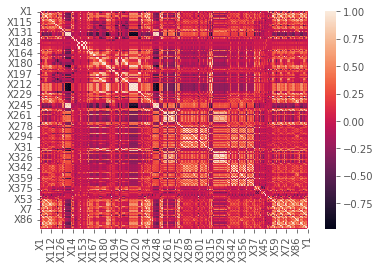

In [145]:
#examine heat map for Y1 dataframe
# get the start time
st = time.process_time()

#examine correlation heat map
sns.heatmap(New_Y1.corr())

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

From the Y1 correlation heatmap, it shows the covariance between some variables. The correlation matrix indicates that most 
variables have a correlation between -0.5 and 0.5. There are too many variables to underpin major dependent variables.

Execution time: 0.0890625 minutes


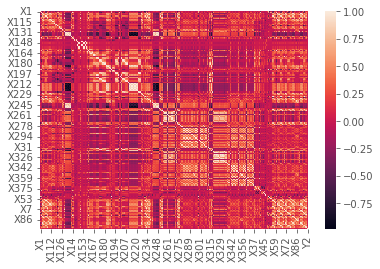

In [146]:
#examine heat map for Y2 dataframe
# get the start time
st = time.process_time()

#examine correlation heat map
sns.heatmap(New_Y2.corr())

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

From the Y2 correlation heatmap, it shows the covariance between some variables. The correlation matrix indicates that most 
variables have a correlation between -0.5 and 0.5. There are too many variables to underpin major dependent variables.

# Explore Calibration Models

We examine 3 samples for in-sample:

    -Entire day dataset
    -AM dataset first hour
    -PM data last hour


# 1.2 Variable Selection

We use 2 techniques for variable selection:

__Variance based feature selection__: Variance Threshold is a feature selector that removes all the low variance features from the dataset that are of no great use in modeling. High variance in predictors is a good indication. Low variance predictors is good for model.
    
__ANOVA__: It is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.
    

# Variance based selection for Y1

Variance Thresholding: This technique is a quick way of eliminating features with very low variance. 
It removes all features whose variance doesn’t meet some threshold as it is assumed that features with a 
higher variance may contain more useful information.

In [74]:
#assign variables names for Y1 
Y1 = New_Y1.iloc[:,375]
x1 = New_Y1.iloc[:,0:375]


In [151]:
#selection based on variance
#to calculate variance
variances = np.var(x1, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

In [152]:
# calling keys() function
columns = x1.keys()


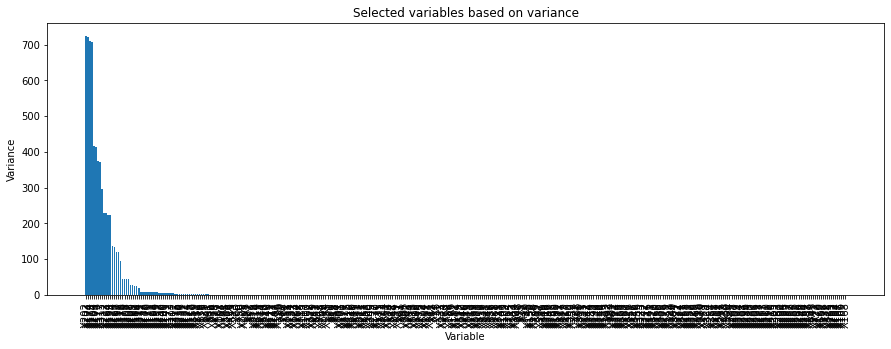

In [153]:
# Select variables based on variance

# calculate variance for each variable
variances = np.var(x1, axis=0)
sorted_indices = np.argsort(variances)[::-1]

# graph
plt.figure(figsize=(15, 5))
plt.bar(x=columns[sorted_indices], height=variances[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Variance')
plt.title('Selected variables based on variance')
plt.show()

The grah shows that there are too many variables to underpin the most insightful.

In [154]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

#apply threshold variance
threshold = 0.8 * (1 - 0.8) #can be modified
selector = VarianceThreshold(threshold=threshold)
X_high_variance = selector.fit_transform(x1)

#print selected variables
selected_columns = columns[selector.get_support()]
print(f"Selected variables variance threshold technique: {selected_columns}")

Selected variables variance threshold technique: Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X83', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98'],
      dtype='object', length=176)


In [155]:
print(selected_columns)

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X83', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98'],
      dtype='object', length=176)


The variance threshold feature selection technique is too simplistic for our dataset. It leads to 176 variables.

# ANOVA Selection for Y1

__Analysis of Variance__ is a statistical method, used to check the means of two or more groups that are significantly 
different from each other. It assumes Hypothesis as

    -H0: Means of all groups are equal.
    -H1: At least one mean of the groups are different.

We filter ANOVA selection to k = 5 variables.

In [158]:
#select best variables with SelectKBest and ANOVA
# K= 5 features
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x1, Y1)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X121', 'X140', 'X141', 'X233', 'X253'], dtype='object')


The selected 5 variables are mentionned above.

# Ridge-Lasso-Elastic Net Regression for Y1

__Ridge Regression__: It is a linear regression model whose coefficients are estimated not by 
ordinary least squares (OLS), but by an estimator, called ridge estimator, that, albeit biased, has lower 
variance than the OLS estimator.

__Lasso Regresion__: Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data 
values are shrunk towards a central point, like the mean. This particular type of regression is well-suited 
for models showing high levels of muticollinearity or when you want to automate certain parts of model selection, 
like variable selection parameter elimination.

__Elastic Net Regression__: Elastic net is a popular type of regularized linear regression that combines two popular 
penalties, specifically the L1 and L2 penalty functions.Elastic Net is an extension of linear regression that adds regularization 
penalties to the loss function during training.

In [75]:
#divise train-test data for 2/3 train and 1/3 test

train, test = train_test_split(New_Y1, test_size=0.33, random_state=42)

In [76]:
#summarize statistics
train.describe()

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
count,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,...,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000,700493.000000
mean,0.049714,0.007488,0.000360,0.000066,0.001087,0.000719,0.006389,0.005148,0.005964,0.012700,...,-0.000116,0.000556,0.000352,0.043849,0.023981,0.046591,0.075057,0.039771,0.000254,-0.178702
std,0.820647,0.643405,0.601413,0.554116,0.469604,0.445122,0.431924,0.738523,0.663486,0.554498,...,0.529864,0.451485,0.427755,0.554540,0.895675,0.878526,0.708974,0.686752,0.368921,13.181214
min,-5.897792,-4.581344,-7.145106,-6.359716,-6.556683,-5.390165,-3.857813,-6.845995,-6.243231,-6.899178,...,-6.383201,-6.623205,-5.441763,-4.431921,-6.560567,-8.132775,-6.867032,-5.682934,-3.573954,-130.271030
25%,-0.480346,-0.337648,-0.379159,-0.348570,-0.291961,-0.274500,-0.268418,-0.471683,-0.422905,-0.341882,...,-0.331111,-0.278998,-0.261734,-0.283104,-0.536838,-0.475454,-0.350967,-0.363610,-0.225394,-7.055057
50%,0.056147,0.009184,-0.006153,-0.005899,-0.002413,-0.002100,0.004138,-0.003217,-0.002696,0.006004,...,-0.005737,-0.002285,-0.002184,0.029342,0.020711,0.024231,0.058563,0.027609,-0.000608,0.000000
75%,0.585727,0.357564,0.373437,0.341188,0.289658,0.270641,0.276692,0.475310,0.426086,0.359005,...,0.323756,0.276385,0.257840,0.348311,0.586213,0.540024,0.482768,0.427679,0.224784,6.643967
max,5.413703,4.270282,6.984492,6.087287,4.176604,4.063385,5.526305,6.499281,5.690257,4.255804,...,6.272851,4.217132,4.066954,5.563794,6.690734,8.302541,5.309231,4.945134,5.743363,90.394500


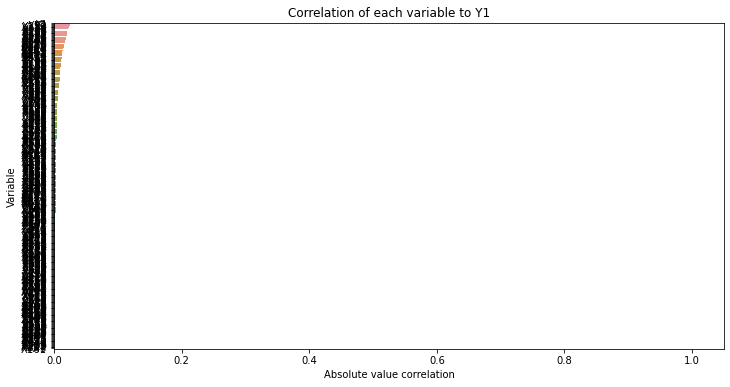

In [161]:
#calculate correlation between each variable and target variables in absolute value
correlations = abs(train.corr()["Y1"]).sort_values(ascending=False)

#graph of correlations
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Absolute value correlation")
plt.ylabel("Variable")
plt.title("Correlation of each variable to Y1")
plt.show()

The graph shows that there are too many variables to underpin the most insightful.

In [163]:
#to find 10 variables with largest correlation
print(correlations.nlargest(10))

Y1      1.000000
X2      0.027588
X52     0.024760
X230    0.024408
X119    0.023035
X4      0.022584
X375    0.022141
X118    0.021958
X232    0.021006
X206    0.020691
Name: Y1, dtype: float64


The 5 highest correlated variables are: X2, X52, X230, X119, X4.

To reduce computational time, we take fraction of sample and memory capacity.


In [167]:
#assign variables names for Y1 
Y1 = New_Y1.iloc[:,375]
x1 = New_Y1.iloc[:,0:375]

New_Y1 = New_Y1.sample(frac = 0.1)
#take 10% of original metadata as sample to analyze models
Y1 = Y1.sample(frac = 0.10)
x1 = x1.sample(frac = 0.10)

In [168]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(New_Y1, test_size=0.33, random_state=42)

In [169]:
import statsmodels.api as sm
#to separate predicted variables and target variable
X_train = train.drop("Y1", axis=1)
y_train = train["Y1"]


X_test = test.drop("Y1", axis=1)
y_test = test["Y1"]

#fit linear model
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#print results in table format
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-2.814648e-01,6.356977e-02,-4.427652,9.540903e-06,-4.060614e-01,-1.568682e-01
X1,-7.451393e+05,1.583032e+06,-0.470704,6.378538e-01,-3.847879e+06,2.357601e+06
X10,2.500557e+06,1.332046e+06,1.877230,6.049078e-02,-1.102512e+05,5.111365e+06
X100,2.989989e+02,9.544574e+01,3.132658,1.733027e-03,1.119254e+02,4.860724e+02
X101,-1.753955e+06,1.085268e+06,-1.616149,1.060667e-01,-3.881078e+06,3.731686e+05
...,...,...,...,...,...,...
X95,-9.079148e-01,3.187963e+00,-0.284795,7.758023e-01,-7.156316e+00,5.340486e+00
X96,5.242671e+05,6.673316e+05,0.785617,4.320945e-01,-7.837015e+05,1.832236e+06
X97,2.569505e+01,4.012193e+00,6.404239,1.520790e-10,1.783116e+01,3.355894e+01
X98,-1.310700e+06,1.668329e+06,-0.785637,4.320831e-01,-4.580622e+06,1.959221e+06


In [170]:
#summary model
lr_model.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.018
1,Dependent Variable:,Y1,AIC:,560164.8587
2,Date:,2023-12-09 04:22,BIC:,563608.1028
3,No. Observations:,70092,Log-Likelihood:,-2.7971e+05
4,Df Model:,375,F-statistic:,4.373
5,Df Residuals:,69716,Prob (F-statistic):,8.02e-155
6,R-squared:,0.023,Scale:,172.19


In [171]:
#to obtain prediction and metric values of performance
y_train_pred = lr_model.predict(sm.add_constant(X_train))
y_test_pred = lr_model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [172]:
#to construct table
df_metrics = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Metric       Train        Test
0     R2    0.022979    0.005201
1    MSE  171.270765  175.725996
2   RMSE   13.087046   13.256168


We notice a slight increase in RMSE for test compared to train.

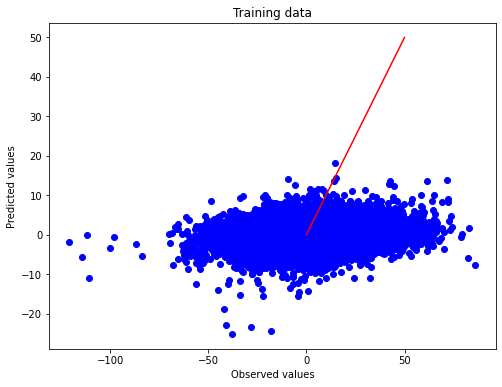

In [114]:
#plot observed values in function of predicted values in train data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Training data')
plt.plot(np.arange(0, 55, 5), np.arange(0, 55, 5), color='red')
plt.show()

We notice a scatter plot of observed values.

__Homoscedasticity__: It states that the variance of error terms are similar across the values of the 
independent variables.  A plot of standardized residuals versus predicted values can show whether points are 
equally distributed across all values of the independent variables.

C:\Users\CanBec\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


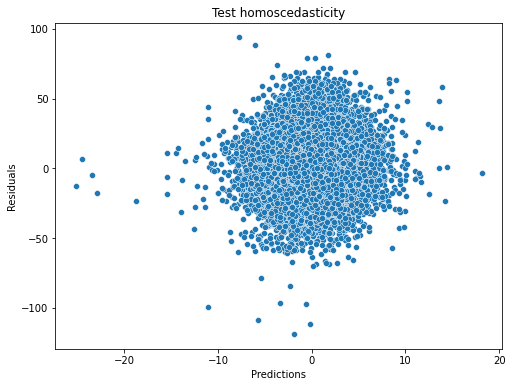

In [115]:
#verify homoscedasticity
y_train_pred = lr_model.predict(sm.add_constant(X_train))
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(y_train_pred, residuals)
plt.title('Test homoscedasticity')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

The graph shows that the data is homoscedastic. A scatterplot of residuals versus predicted values is good way to 
check for homoscedasticity. There should be no clear pattern in the distribution; if there is a cone-shaped pattern, the 
data is heteroscedastic.

__Breusch-Pagan Test__: It is used to determine whether or not heteroscedasticity is present in a regression model.
If the p-value of the test is less than some significance level (i.e. α = .05) then we reject the null hypothesis and 
conclude that heteroscedasticity is present in the regression model.

In [173]:
# Test Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(lr_model.resid, lr_model.model.exog)
print("Test Breusch-Pagan : statistic = %f, p-value = %f" % (bp_test[0], bp_test[1]))

Test Breusch-Pagan : statistic = 3952.660633, p-value = 0.000000


p-value = 0.00000 which is < 0.05, we conclude the presence of heteroscedasticity is present in the regression model.

# Ridge Lasso Elastic Net for Y1 with 5 highest correlated variables

In [174]:
#The 5 highest correlated variables are: X2 X52, X230, X119, X4.
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y1'],
      dtype='object', length=376)

In [175]:
new_selection=['X2', 'X52','X30','X119','X4']
train_selectedb = train[new_selection]
train_selectedb["Y1"] = train['Y1']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_14596\1129693965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y1"] = train['Y1']


,X2,X52,X30,X119,X4,Y1
374007,-0.275469,-0.831069,-0.030961,0.000000,-0.371065,7.650459
948675,0.579159,-0.443800,0.069538,0.000000,1.068256,12.319244
2102702,0.040719,-0.138333,0.066623,0.000000,0.211030,-17.291620
85581,0.145635,0.064849,-0.043723,0.000000,0.535941,2.127943
1696013,-0.874068,-0.371835,0.088581,0.450606,-0.535640,10.100110
...,...,...,...,...,...,...
1893556,0.301002,0.132776,0.015193,0.000000,0.082394,-22.892498
1038558,-0.753301,-0.637066,0.082473,0.458120,-0.943071,-17.822750
572720,0.043847,-0.276358,-0.097257,-0.118404,-0.030809,12.324040
232885,-0.555773,-0.415736,-0.012158,0.000000,-0.437343,-7.631715


In [176]:
import statsmodels.api as sm
#separate predict variables from target variable
X_train = train_selectedb.drop("Y1", axis=1)
y_train = train_selectedb["Y1"]

#fit linear model
lr_modelb = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#get results in table format
results_table = lr_modelb.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-0.277390,0.052927,-5.241047,1.601288e-07,-0.381126,-0.173655
X2,-0.541770,0.183027,-2.960049,3.076926e-03,-0.900503,-0.183037
X52,-0.200101,0.119012,-1.681345,9.270029e-02,-0.433365,0.033163
X30,0.305444,0.547965,0.557415,5.772454e-01,-0.768565,1.379453
X119,-0.353842,0.040711,-8.691633,3.648052e-18,-0.433635,-0.274049
X4,0.302666,0.179771,1.683619,9.225972e-02,-0.049685,0.655017


In [177]:
lr_modelb.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.002
1,Dependent Variable:,Y1,AIC:,560927.4423
2,Date:,2023-12-09 04:27,BIC:,560982.3877
3,No. Observations:,70092,Log-Likelihood:,-2.8046e+05
4,Df Model:,5,F-statistic:,25.39
5,Df Residuals:,70086,Prob (F-statistic):,1.10e-25
6,R-squared:,0.002,Scale:,175.00


VIF: Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple 
regression variables.

In [180]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#vif factor 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Variables"] = X_train.columns
print(vif)

   VIF Factor Variables
0    5.638085        X2
1    2.093826       X52
2    1.076020       X30
3    1.016099      X119
4    4.193384        X4


In [181]:
import statsmodels.api as sm
#separates predict variables from target variable
X_train = train.drop("Y1", axis=1)
y_train = train["Y1"]

#fit linear model
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#obtain results
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-2.814648e-01,6.356977e-02,-4.427652,9.540903e-06,-4.060614e-01,-1.568682e-01
X1,-7.451393e+05,1.583032e+06,-0.470704,6.378538e-01,-3.847879e+06,2.357601e+06
X10,2.500557e+06,1.332046e+06,1.877230,6.049078e-02,-1.102512e+05,5.111365e+06
X100,2.989989e+02,9.544574e+01,3.132658,1.733027e-03,1.119254e+02,4.860724e+02
X101,-1.753955e+06,1.085268e+06,-1.616149,1.060667e-01,-3.881078e+06,3.731686e+05
...,...,...,...,...,...,...
X95,-9.079148e-01,3.187963e+00,-0.284795,7.758023e-01,-7.156316e+00,5.340486e+00
X96,5.242671e+05,6.673316e+05,0.785617,4.320945e-01,-7.837015e+05,1.832236e+06
X97,2.569505e+01,4.012193e+00,6.404239,1.520790e-10,1.783116e+01,3.355894e+01
X98,-1.310700e+06,1.668329e+06,-0.785637,4.320831e-01,-4.580622e+06,1.959221e+06


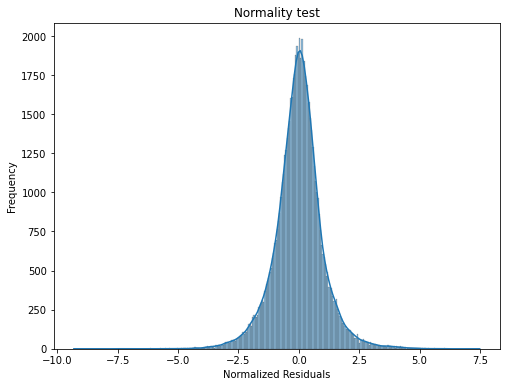

In [182]:
#Verify normality
resid_norm = lr_model.get_influence().resid_studentized_internal
plt.figure(figsize=(8, 6))
sns.histplot(resid_norm, kde=True)
plt.title('Normality test')
plt.xlabel('Normalized Residuals')
plt.ylabel('Frequency')
plt.show()

The bell curve shows a normal distribution.

__QQ Plot__: A graphical method for comparing two probability distributions by plotting their quantiles against each other.

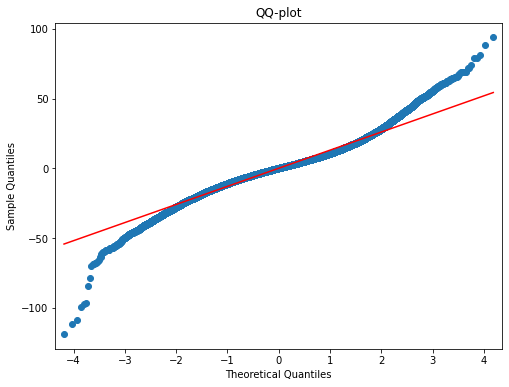

In [125]:
# QQ-plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ-plot')
plt.show()

QQ Plot shows that the dataset deviates from the normality red line especially in the tails of the distribution.

__Test Shapiro-Wilk__: It is a test of normality. It is used to determine whether or not a sample comes 
from a normal distribution.If the chosen alpha level is 0.05 and the p-value is less than 0.05, then the null 
hypothesis that the data are normally distributed is rejected. If the p-value is greater than 0.05, then the 
null hypothesis is not rejected.
    
__Test Anderson-Darling__: It is used to test if a sample of data came from a population with a specific distribution. 
It is a modification of the Kolmogorov-Smirnov (K-S) test and gives more weight to the tails than does the K-S test. 
If the p-value is less than alpha generally set at 0.05 then we reject the null hypotheses that the data are from a 
normal distribution.
    
__Test Kolmogorov-Smirnov__: It is used to decide if a sample comes from a population with a specific distribution.
It quantifies a distance between the empirical distribution function of the sample and the cumulative distribution 
function of the reference distribution, or between the empirical distribution functions of two samples.
The p-value is interpretated the same way as the other normality tests.

In [183]:
import scipy.stats as stats

# Test Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Test Anderson-Darling
anderson_test = stats.anderson(residuals, dist='norm')

# Test Kolmogorov-Smirnov
ks_test = stats.kstest(residuals, 'norm')

# put results in dataframe
df_normality = pd.DataFrame({
    'Normality Test': ['Shapiro-Wilk', 'Anderson-Darling', 'Kolmogorov-Smirnov'],
    'Statistic': [shapiro_test.statistic, anderson_test.statistic, ks_test.statistic],
    'p-value': [shapiro_test.pvalue, 'N/A', ks_test.pvalue]
})

# print table
print(df_normality)

       Normality Test  Statistic   p-value
0        Shapiro-Wilk   0.996434  0.117726
1    Anderson-Darling   0.602027       N/A
2  Kolmogorov-Smirnov   0.409024       0.0


The p-value from Shapiro-Wilk test is > 0.05 then we do not reject null hypothesis and conclude that the 
distribution is normally distributed. 

In [184]:
#verify autocorrelation
from statsmodels.stats.stattools import durbin_watson
# autocorrelation test
dw_test = durbin_watson(lr_model.resid)
print("Test de Durbin-Watson : statistique = %f" % dw_test)

Test de Durbin-Watson : statistique = 2.003357


In [185]:
#mean residuals
residuals.mean()

-1.5788730895392536e-08

# Ridge Regression

In [186]:
from sklearn.linear_model import Lasso, LassoCV,RidgeCV,Ridge,ElasticNet,ElasticNetCV
from sklearn.model_selection import train_test_split,cross_val_score

# creates and adjusts model RidgeCV
alphas = np.linspace(0.01, 1, 100) # list of best possible values for parameter alpha
ridge_cv = RidgeCV(alphas=alphas, cv=7) # cv is the number of folds for cross-validation
ridge_cv.fit(X_train, y_train)

# get the best parameter alpha
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

Best alpha: 1.0


# Lasso Regression

In [187]:
from sklearn.linear_model import LassoCV

#creates and adjusts LassoCV model
alphas = [0.001, 1.0, 10.0, 100.0]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

#obtains the best parameter alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4583150.519527748, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4595233.124412877, tolerance: 983.5864820363604
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4570165.625235475, tolerance: 980.0978239709802
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633:

Best alpha: 0.001


C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e+06, tolerance: 1.229e+03
  model = cd_fast.enet_coordinate_descent(


# Elastic Net Regression

In [188]:
#creates a regression model ElasticNet with cross-validation ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-5, 5, 11), cv=5)

#adjusts model to data
model.fit(X_train, y_train)

#finds the best alpha and best l1_ratio
best_alpha = model.alpha_
best_l1_ratio = model.l1_ratio_

#prints the best alpha and best l1_ratio
print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2597582.1570339464, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4563755.912447842, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4820217.626381723, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: 

Best alpha: 0.001
Best l1_ratio: 1.0


C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e+06, tolerance: 1.229e+03
  model = cd_fast.enet_coordinate_descent(


__Summary Ridge-Lasso-Elastic Net for Y1__

In [189]:
#creates models with Ridge Regression, Lasso and ElasticNet with cross-validation
ridge_model = RidgeCV(alphas=np.logspace(-5, 5, 11), cv=5)
lasso_model = LassoCV(alphas=np.logspace(-5, 5, 11), cv=5)
enet_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-5, 5, 11), cv=5)

#adjust model to train data
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
enet_model.fit(X_train, y_train)

#predicts values for train and test data
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)
enet_train_pred = enet_model.predict(X_train)
enet_test_pred = enet_model.predict(X_test)

#calculates R2 and RMSE for train and test data
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_pred))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))
enet_train_r2 = r2_score(y_train, enet_train_pred)
enet_test_r2 = r2_score(y_test, enet_test_pred)
enet_train_rmse = np.sqrt(mean_squared_error(y_train, enet_train_pred))
enet_test_rmse = np.sqrt(mean_squared_error(y_test, enet_test_pred))

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2554723.607097223, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4550639.254862313, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4806110.448129424, tolerance: 985.074095883965
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: C

In [190]:
data = {'Model': ['Ridge', 'Lasso', 'ElasticNet'],
        'R2  train': [ridge_train_r2, lasso_train_r2, enet_train_r2],
'R2  test': [ridge_test_r2, lasso_test_r2, enet_test_r2],
'RMSE train': [ridge_train_rmse, lasso_train_rmse, enet_train_rmse],
'RMSE  test': [ridge_test_rmse, lasso_test_rmse, enet_test_rmse]}

df = pd.DataFrame(data)
df

,Model,R2 train,R2 test,RMSE train,RMSE test
0,Ridge,0.016403,0.007246,13.131014,13.242533
1,Lasso,0.016200,0.007084,13.132373,13.243610
2,ElasticNet,0.016200,0.007084,13.132373,13.243610


The best model for Y1 with 5 highest correlated variables is ridge regression. 

# Variable selection for Y2

In [88]:
#assign variables names for Y2 
Y2 = New_Y2.iloc[:,375]
x2 = New_Y2.iloc[:,0:375]

# ANOVA Selection for Y2

In [89]:
#selection based on variance
#to calculate variance
variances = np.var(x2, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x2.keys()

In [90]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects best variables with SelectKBest and ANOVA
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x2, Y2)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X124', 'X125', 'X128', 'X129', 'X236'], dtype='object')


# Y2 with 5 highest correlated variables

We first perform feature selection for Y2.

In [48]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(New_Y2, test_size=0.33, random_state=42)

In [49]:
#summarize statistics
train.describe()

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y2
count,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,...,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000,700511.000000
mean,0.049586,0.006816,0.000769,0.000391,0.001395,0.000822,0.007234,0.005838,0.006640,0.012749,...,0.000184,0.000999,0.000566,0.045177,0.025397,0.047677,0.075380,0.039738,0.000934,-0.260573
std,0.821783,0.644592,0.603448,0.555701,0.471146,0.446328,0.432382,0.740095,0.664560,0.556422,...,0.531453,0.452935,0.428844,0.555454,0.897225,0.878772,0.710356,0.687444,0.369458,17.838367
min,-5.897792,-4.581344,-7.785913,-7.100880,-7.710001,-5.390165,-4.448535,-8.238065,-7.643802,-7.912608,...,-6.792187,-7.477999,-5.441763,-4.594765,-8.023386,-8.349961,-8.385143,-5.682934,-4.016375,-178.733170
25%,-0.482960,-0.339357,-0.379265,-0.348004,-0.292454,-0.275117,-0.267689,-0.471533,-0.422758,-0.342556,...,-0.330616,-0.279217,-0.261761,-0.282543,-0.535767,-0.473397,-0.351947,-0.364027,-0.224857,-9.992550
50%,0.055112,0.009101,-0.005724,-0.005715,-0.001361,-0.002073,0.005107,-0.001251,-0.002089,0.006855,...,-0.005566,-0.001406,-0.002427,0.030261,0.022776,0.027333,0.059041,0.028920,0.000425,-0.186235
75%,0.587773,0.358017,0.374240,0.342831,0.290758,0.271611,0.277932,0.475772,0.427408,0.359621,...,0.324879,0.277194,0.258686,0.349643,0.586744,0.540844,0.483422,0.428384,0.225030,9.225530
max,5.606843,4.270282,6.883833,5.137062,7.743310,4.592110,3.590878,7.355058,5.690257,7.593247,...,5.126297,7.717176,4.297841,4.715979,8.170010,8.214717,7.730974,4.855236,3.041408,134.221560


# Correlation Feature Selection for Y2

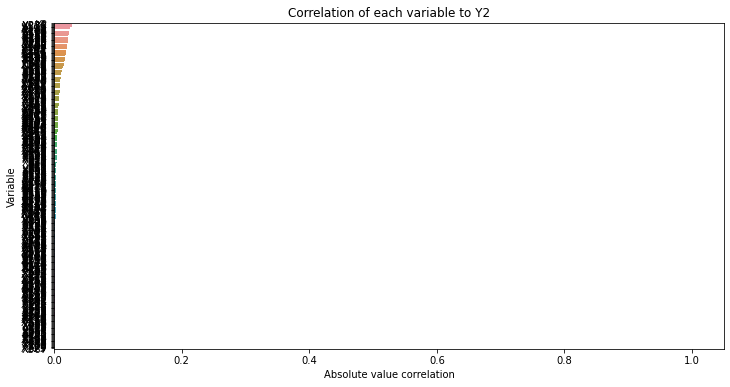

In [50]:
#calculate correlation between each variable and target variables in absolute value
correlations = abs(train.corr()["Y2"]).sort_values(ascending=False)

#graph of correlations
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Absolute value correlation")
plt.ylabel("Variable")
plt.title("Correlation of each variable to Y2")
plt.show()

The grah shows that there are too many variables to underpin the most insightful.

In [51]:
#to find 10 variables with largest correlation
print(correlations.nlargest(10))

Y2      1.000000
X230    0.031151
X231    0.028129
X375    0.027893
X119    0.027416
X197    0.025211
X196    0.025114
X118    0.024535
X206    0.024534
X207    0.024148
Name: Y2, dtype: float64


The 5 highest correlated variables are: X230, X231, X375, X119, X197.

In [52]:
#assign variables names for Y1 
Y2 = New_Y2.iloc[:,375]
x2 = New_Y2.iloc[:,0:375]

New_Y2 = New_Y2.sample(frac = 0.1)
#take 10% of original metadata as sample to analyze models
Y2 = Y2.sample(frac = 0.10)
x2 = x2.sample(frac = 0.10)

In [53]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(New_Y2, test_size=0.33, random_state=42)

# Ridge Lasso Elastic Net for Y2 with 5 highest correlated values.

In [54]:
import statsmodels.api as sm
#to separate predicted variables and target variable
X_train = train.drop("Y2", axis=1)
y_train = train["Y2"]


X_test = test.drop("Y2", axis=1)
y_test = test["Y2"]

#fit linear model
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#print results in table format
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-1.627895e-01,8.603617e-02,-1.892105,5.848111e-02,-3.314202e-01,5.841241e-03
X1,3.109881e+06,2.150858e+06,1.445879,1.482156e-01,-1.105797e+06,7.325559e+06
X10,1.316614e+06,1.796297e+06,0.732960,4.635852e-01,-2.204124e+06,4.837352e+06
X100,2.986063e+02,1.322537e+02,2.257829,2.395942e-02,3.938921e+01,5.578233e+02
X101,4.647278e+06,1.475094e+06,3.150495,1.630629e-03,1.756095e+06,7.538460e+06
...,...,...,...,...,...,...
X95,-6.263008e-01,4.343853e+00,-0.144181,8.853580e-01,-9.140245e+00,7.887643e+00
X96,-1.827355e+06,9.110783e+05,-2.005706,4.489149e-02,-3.613067e+06,-4.164345e+04
X97,2.893552e+01,5.451855e+00,5.307463,1.115004e-07,1.824990e+01,3.962115e+01
X98,4.568347e+06,2.277696e+06,2.005688,4.489339e-02,1.040681e+05,9.032627e+06


In [55]:
lr_model.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.017
1,Dependent Variable:,Y2,AIC:,602471.7696
2,Date:,2023-12-09 12:44,BIC:,605914.7936
3,No. Observations:,70051,Log-Likelihood:,-3.0086e+05
4,Df Model:,375,F-statistic:,4.135
5,Df Residuals:,69675,Prob (F-statistic):,2.62e-140
6,R-squared:,0.022,Scale:,316.47


In [56]:
#to obtain prediction and metric values of performance
y_train_pred = lr_model.predict(sm.add_constant(X_train))
y_test_pred = lr_model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [57]:
#construct table with results

df_metrics = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Metric       Train        Test
0     R2    0.021769   -0.000089
1    MSE  314.776041  313.315128
2   RMSE   17.741929   17.700710


C:\Users\CanBec\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


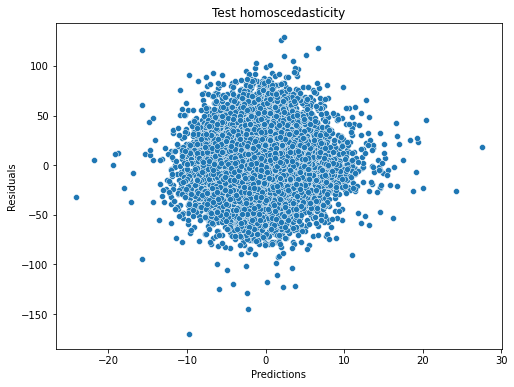

In [20]:
# verify homoscedasticity
y_train_pred = lr_model.predict(sm.add_constant(X_train))
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(y_train_pred, residuals)
plt.title('Test homoscedasticity')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Graph shows that data is homoscedastic.

In [58]:
# Test de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(lr_model.resid, lr_model.model.exog)
print("Test Breusch-Pagan : statistique = %f, p-value = %f" % (bp_test[0], bp_test[1]))

Test Breusch-Pagan : statistique = 5062.412295, p-value = 0.000000


p-value test Breusch-Pagan > 0.05, we conclude that data is not heteroscedastic.

In [59]:
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y2'],
      dtype='object', length=376)

In [60]:
#The 5 highest correlated variables are: X230, X231, X375, X119, X197.
new_selection=['X230', 'X231','X375','X119','X197']
train_selectedb = train[new_selection]
train_selectedb["Y2"] = train['Y2']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_9364\1335496456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y2"] = train['Y2']


,X230,X231,X375,X119,X197,Y2
1663289,-1.079614,-0.814774,-1.985865,0.000000,-10.974749,-11.480947
380388,4.653534,4.064244,-2.504697,4.064244,-10.208534,74.474810
794133,0.014394,-0.095318,2.522844,-0.095318,0.248908,-6.343053
224552,0.000297,-0.010826,-0.843141,-0.010826,3.635752,3.368245
1467524,1.109154,0.785009,0.943160,0.000000,10.445845,1.238598
...,...,...,...,...,...,...
1721112,0.984398,0.809128,-1.964804,0.809128,-5.919529,-18.905577
194880,0.098754,-0.097377,0.982247,0.000000,-0.683741,9.186478
1267293,-0.464035,-0.663952,-0.230118,0.000000,-1.122723,-5.486421
2148733,0.180445,0.165202,-0.922683,0.000000,4.134745,7.518033


In [61]:
import statsmodels.api as sm
#separate predict variables from target variable
X_train = train_selectedb.drop("Y2", axis=1)
y_train = train_selectedb["Y2"]

#fit linear model
lr_modelb = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#get results in table format
results_table = lr_modelb.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-0.202749,0.070383,-2.880645,0.003970,-0.340700,-0.064798
X230,-0.209359,0.067170,-3.116851,0.001829,-0.341013,-0.077706
X231,0.084548,0.110179,0.767368,0.442865,-0.131403,0.300498
X375,-0.281903,0.060194,-4.683206,0.000003,-0.399883,-0.163922
X119,-0.343104,0.127698,-2.686837,0.007215,-0.593392,-0.092816
X197,-0.023966,0.009896,-2.421706,0.015450,-0.043363,-0.004569


In [62]:
lr_modelb.summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.002
1,Dependent Variable:,Y2,AIC:,603136.5452
2,Date:,2023-12-09 12:45,BIC:,603191.4871
3,No. Observations:,70051,Log-Likelihood:,-3.0156e+05
4,Df Model:,5,F-statistic:,27.43
5,Df Residuals:,70045,Prob (F-statistic):,7.78e-28
6,R-squared:,0.002,Scale:,321.18


__VIF__: Variance inflation factor is a measure of the amount of multicollinearity in a set of multiple regression variables.

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#vif factor 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Variables"] = X_train.columns
print(vif)

   VIF Factor Variables
0    2.107118      X230
1    5.035045      X231
2    2.243677      X375
3    5.097691      X119
4    2.586965      X197


In [64]:
import statsmodels.api as sm
#separates predict variables from target variable
X_train = train.drop("Y2", axis=1)
y_train = train["Y2"]

#fit linear model
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

#obtain results
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-1.627895e-01,8.603617e-02,-1.892105,5.848111e-02,-3.314202e-01,5.841241e-03
X1,3.109881e+06,2.150858e+06,1.445879,1.482156e-01,-1.105797e+06,7.325559e+06
X10,1.316614e+06,1.796297e+06,0.732960,4.635852e-01,-2.204124e+06,4.837352e+06
X100,2.986063e+02,1.322537e+02,2.257829,2.395942e-02,3.938921e+01,5.578233e+02
X101,4.647278e+06,1.475094e+06,3.150495,1.630629e-03,1.756095e+06,7.538460e+06
...,...,...,...,...,...,...
X95,-6.263008e-01,4.343853e+00,-0.144181,8.853580e-01,-9.140245e+00,7.887643e+00
X96,-1.827355e+06,9.110783e+05,-2.005706,4.489149e-02,-3.613067e+06,-4.164345e+04
X97,2.893552e+01,5.451855e+00,5.307463,1.115004e-07,1.824990e+01,3.962115e+01
X98,4.568347e+06,2.277696e+06,2.005688,4.489339e-02,1.040681e+05,9.032627e+06


In [65]:
import scipy.stats as stats

# Test Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Test Anderson-Darling
anderson_test = stats.anderson(residuals, dist='norm')

# Test Kolmogorov-Smirnov
ks_test = stats.kstest(residuals, 'norm')

# put results in dataframe
df_normality = pd.DataFrame({
    'Normality Test': ['Shapiro-Wilk', 'Anderson-Darling', 'Kolmogorov-Smirnov'],
    'Statistic': [shapiro_test.statistic, anderson_test.statistic, ks_test.statistic],
    'p-value': [shapiro_test.pvalue, 'N/A', ks_test.pvalue]
})

# print table
print(df_normality)

       Normality Test   Statistic p-value
0        Shapiro-Wilk    0.972230     0.0
1    Anderson-Darling  394.198210     N/A
2  Kolmogorov-Smirnov    0.423483     0.0


C:\Users\CanBec\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The p-value from Shapiro-Wilk test is < 0.05 then we do reject null hypothesis and conclude that the distribution is not normally distributed.

In [66]:
#verify autocorrelation
from statsmodels.stats.stattools import durbin_watson
# autocorrelation test
dw_test = durbin_watson(lr_model.resid)
print("Test Durbin-Watson : statistic = %f" % dw_test)

Test Durbin-Watson : statistic = 2.005417


In [67]:
#mean residuals
residuals.mean()

5.412806769764781e-09

# Ridge Regression

In [68]:
from sklearn.linear_model import Lasso, LassoCV,RidgeCV,Ridge,ElasticNet,ElasticNetCV
from sklearn.model_selection import train_test_split,cross_val_score

#creates and adjusts model RidgeCV
alphas = np.linspace(0.01, 1, 100) #creates list of possible alphas
ridge_cv = RidgeCV(alphas=alphas, cv=7) # cv is the number of folds for cross-validation 
ridge_cv.fit(X_train, y_train)

# get best alpha parameter
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

Best alpha: 0.92


# Lasso Regression

In [69]:
from sklearn.linear_model import LassoCV

# creates and adjusts model LassoCV
alphas = [0.001, 1.0, 10.0, 100.0]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# get the best parameter alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8611865.17585492, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8589327.716803191, tolerance: 1798.0549672098111
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8523916.85779925, tolerance: 1792.16924067554
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: C

Best alpha: 0.001


C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+07, tolerance: 2.254e+03
  model = cd_fast.enet_coordinate_descent(


# Elastic Net Regression

In [70]:
#creates a regression model ElasticNet with cross-validation of ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-5, 5, 11), cv=5)

#adjusts model to data
model.fit(X_train, y_train)

#finds the best alpha and best l1_ratio
best_alpha = model.alpha_
best_l1_ratio = model.l1_ratio_

#prints the best alpha and best l1_ratio
print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6288949.113941746, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8594212.558212651, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8836337.6384609, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Con

Best alpha: 0.01
Best l1_ratio: 1.0


C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.850e+06, tolerance: 2.254e+03
  model = cd_fast.enet_coordinate_descent(


Summary 3 regressions

In [71]:
#creates models for Ridge regression, Lasso and ElasticNet with cross-validation
ridge_model = RidgeCV(alphas=np.logspace(-5, 5, 11), cv=5)
lasso_model = LassoCV(alphas=np.logspace(-5, 5, 11), cv=5)
enet_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-5, 5, 11), cv=5)

#adjust models to train data
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
enet_model.fit(X_train, y_train)

#predicts values on train and test data
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)
enet_train_pred = enet_model.predict(X_train)
enet_test_pred = enet_model.predict(X_test)

#calculates R2 and RMSE for train and test data
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_pred))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))
enet_train_r2 = r2_score(y_train, enet_train_pred)
enet_test_r2 = r2_score(y_test, enet_test_pred)
enet_train_rmse = np.sqrt(mean_squared_error(y_train, enet_train_pred))
enet_test_rmse = np.sqrt(mean_squared_error(y_test, enet_test_pred))

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5294.963868398219, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5560104.39133284, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8588120.2294631, tolerance: 1799.47832852786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Conv

In [72]:
data = {'Model': ['Ridge', 'Lasso', 'ElasticNet'],
        'R2  train': [ridge_train_r2, lasso_train_r2, enet_train_r2],
'R2  test': [ridge_test_r2, lasso_test_r2, enet_test_r2],
'RMSE train': [ridge_train_rmse, lasso_train_rmse, enet_train_rmse],
'RMSE  test': [ridge_test_rmse, lasso_test_rmse, enet_test_rmse]}

df = pd.DataFrame(data)
df

,Model,R2 train,R2 test,RMSE train,RMSE test
0,Ridge,0.015261,0.005491,17.800851,17.651260
1,Lasso,0.011021,0.005744,17.839133,17.649013
2,ElasticNet,0.011021,0.005744,17.839133,17.649013


The best model model for Y2 with the 5 highest correlated variables is Ridge Regression.

We retain Ridge Regression as best model for Y1 and Y2 with correlation feature selection.

# 1.3 Entire Day Dataset with 5 variables selected ANOVA

We use a fraction to find new ANOVA variables for Y1 and Y2.

In [28]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y2
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)


In [30]:
#assign variables names for Y1 
Y1 = New_Y1["Y1"]
x1 = New_Y1.drop(["Y1"], axis =1)

Y1 = Y1.sample(frac = 0.1)
x1 = x1.sample(frac = 0.1)

#assign variables names for Y2 
Y2 = New_Y2["Y2"]
x2 = New_Y2.drop(["Y2"], axis =1)

Y2 = Y2.sample(frac = 0.1)
x2 = x2.sample(frac = 0.1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, x1.shape, x2.shape))


Shape of new dataframes - (104564,) , (104583,), (104564, 375), (104583, 375)


# Feature Selection Y1

In [31]:
#selection based on variance
#to calculate variance
variances = np.var(x1, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x1.keys()

In [32]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects the best variables with SelectKBest and ANOVA
# K = 5 variables
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x1, Y1)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X114', 'X115', 'X126', 'X288', 'X303'], dtype='object')


# Feature Selection Y2

In [33]:
#selection based on variance
#to calculate variance
variances = np.var(x2, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x2.keys()

In [34]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects the best variables with SelectKBest and ANOVA
# K = 5 variables
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x2, Y2)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X123', 'X124', 'X125', 'X128', 'X129'], dtype='object')


To reduce computational time, we examine a metadata sample containing a fraction of the initial massive dataset. 

__We explore various forecasting techniques__:

__Multilayer Perception Regression (MLP)__

__Random Forest Regression__

__Stepwise linear regression__

__Ridge Regression Model__

__Lasso Regression Model__

Because metadata is memory consuming and increases computational time, we take samples to perform tests on models.

In [7]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y2
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)

In [8]:
#assign variables names for x1 
Anova_x1 = New_Y1[["X114", "X115", "X126", "X288", "X303"]]
#fraction
Anova_x1 = Anova_x1.sample(frac=0.1)

#assign variables names for x2 
Anova_x2 = New_Y2[["X123", "X124", "X125", "X128", "X129"]]
#fraction
Anova_x2 = Anova_x2.sample(frac=0.1)

In [36]:
print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, Anova_x1.shape, Anova_x2.shape))

Shape of new dataframes - (104564,) , (104583,), (104564, 5), (104583, 5)


# Split data Train-Test

For the remainder of the models, we take 2/3 of dataset to train and 1/3 to test. 

In [37]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(Anova_x1, Y1, test_size=0.33, random_state=42, shuffle=True)

In [38]:
#for Y2
x_train2, x_test2, y_train2, y_test2 = train_test_split(Anova_x2, Y2, test_size=0.33, random_state=42, shuffle=True)

In [39]:
#for Y1
print('Number of lines in training set for Y1 is',len(x_train))
print('Number of lines in testing set for Y1 is',len(x_test))
#for Y2
print('Number of lines in training set for Y2 is',len(x_train2))
print('Number of lines in testing set for Y2 is',len(x_test2))

Number of lines in training set for Y1 is 70057
Number of lines in testing set for Y1 is 34507
Number of lines in training set for Y2 is 70070
Number of lines in testing set for Y2 is 34513


# Multilayer Perception Regression (MLP)

MLP regression is an artificial neural network the uses backpropagation to adjust the weights between neurons. 
Precisely, it uses three or more layers of perceptrons whereas the data flows in a single direction. 

In [40]:
#for Y1
sc=StandardScaler()

scaler = sc.fit(x_train)
trainX_scaled = scaler.transform(x_train)
testX_scaled = scaler.transform(x_test)

In [41]:
#for Y1
mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(trainX_scaled, y_train)

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=300)

In [42]:
#for Y1
y_pred = mlp_reg.predict(testX_scaled)
df_temp = pd.DataFrame({'Actual Y1': y_test, 'Predicted Y1': y_pred})
df_temp.head()

,Actual Y1,Predicted Y1
772410,10.046212,-0.101279
1312131,6.576604,3.151718
103210,-3.205899,-0.310088
549252,6.107209,-0.101279
2151336,1.538651,-0.414277


In [43]:
#for Y1
print('Mean Absolute Error MLP Y1:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error  MLP Y1:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error  MLP Y1:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error MLP Y1: 9.804067405344261
Mean Squared Error  MLP Y1: 181.596608533021
Root Mean Squared Error  MLP Y1: 13.475778587266154


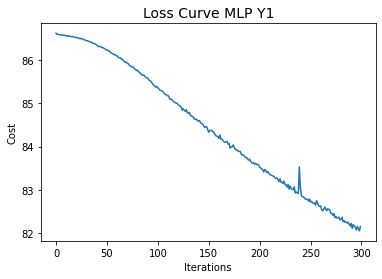

In [44]:
#for Y1
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve MLP Y1", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

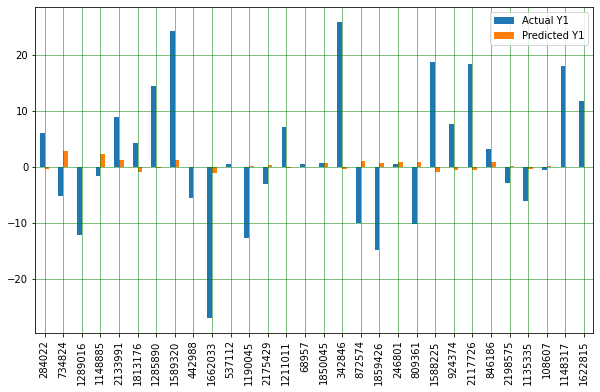

In [167]:
#for Y1
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [45]:
#for Y2
sc=StandardScaler()

scaler = sc.fit(x_train2)
trainX_scaled2 = scaler.transform(x_train2)
testX_scaled2 = scaler.transform(x_test2)

In [46]:
#for Y2
mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(trainX_scaled2, y_train2)

C:\Users\CanBec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=300)

In [47]:
#for Y2
y_pred = mlp_reg.predict(testX_scaled2)
df_temp = pd.DataFrame({'Actual Y2': y_test2, 'Predicted Y2': y_pred})
df_temp.head()

,Actual Y2,Predicted Y2
123828,-18.214787,2.561444
1755265,38.022810,-0.238828
2059205,-1.944621,-0.042999
1598864,-38.222820,-1.516988
2220678,-12.925421,-0.238828


In [48]:
#for Y2
print('Mean Absolute Error MLP Y2:', metrics.mean_absolute_error(y_test2, y_pred))  
print('Mean Squared Error  MLP Y2:', metrics.mean_squared_error(y_test2, y_pred))  
print('Root Mean Squared Error  MLP Y2:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred)))

Mean Absolute Error MLP Y2: 13.327834746200525
Mean Squared Error  MLP Y2: 330.0385179244533
Root Mean Squared Error  MLP Y2: 18.166962264628978


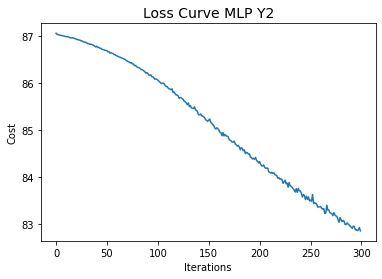

In [173]:
#for Y2
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve MLP Y2", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

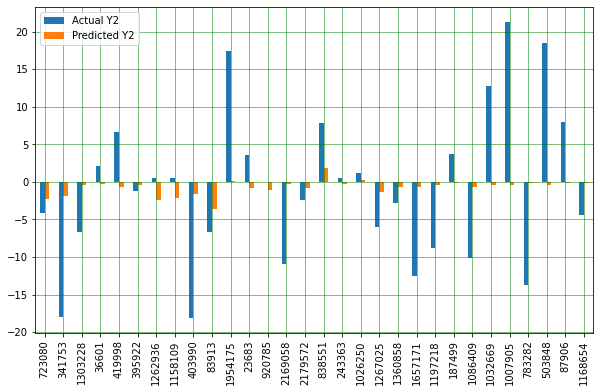

In [174]:
#for Y2
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Random Forest Regression

Random Forest regression creates multiple decision trees by splitting the dataset based on random numbers then makes 
predictions for all individual decision trees to finally average the regression results. We use 30 trees to avoid
overfitting the data.

In [49]:
# Initializing the Random Forest Regression model with 30 decision trees
model = RandomForestRegressor(n_estimators = 30, random_state = 0)

In [50]:
#Y1
# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train) 

RandomForestRegressor(n_estimators=30, random_state=0)

In [51]:
#Y1
# Predicting the target values of the test set
y_pred = model.predict(x_test)

In [52]:
#Y1
print('Mean Absolute Error Random Forest Y1:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error  Random Forest Y1:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error  Random Forest Y1:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error Random Forest Y1: 10.300019989225829
Mean Squared Error  Random Forest Y1: 195.7778058091332
Root Mean Squared Error  Random Forest Y1: 13.99206224289805


In [53]:
#Y2
# Fitting the Random Forest Regression model to the data
model.fit(x_train2, y_train2) 

RandomForestRegressor(n_estimators=30, random_state=0)

In [54]:
#Y2
# Predicting the target values of the test set
y_pred = model.predict(x_test2)

In [55]:
#for Y2
print('Mean Absolute Error Random Forest Y2:', metrics.mean_absolute_error(y_test2, y_pred))  
print('Mean Squared Error  Random Forest Y2:', metrics.mean_squared_error(y_test2, y_pred))  
print('Root Mean Squared Error  Random Forest Y2:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred)))

Mean Absolute Error Random Forest Y2: 14.131867385123162
Mean Squared Error  Random Forest Y2: 360.1823699281671
Root Mean Squared Error  Random Forest Y2: 18.97847122210235


# Stepwise linear regression



Before we can start selecting features, we need a way to measure the performance of our model.
Cross-validation is a popular technique for doing this, which involves splitting the data into multiple folds, training the model on each fold and testing it on the remaining folds. 
This allows us to estimate the model's performance on new, unseen data.

In [59]:
Anova_x1 = Anova_x1.to_numpy()
Y1 = Y1.to_numpy()

In [60]:

#for Y1
# Define the number of folds
n_folds = 5

# Initialize a KFold object
kf = KFold(n_splits=n_folds, shuffle=True)

# Initialize a list to store the cross-validation scores
cv_scores = []

# Loop over the folds
for train_index, test_index in kf.split(Anova_x1):
    # Split the data into training and test sets
    X_train, X_test = Anova_x1[train_index], Anova_x1[test_index]
    y_train, y_test = Y1[train_index], Y1[test_index]
    # Fit a linear regression model
    model = LinearRegression().fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Calculate the R^2 score
    score = r2_score(y_test, y_pred)
    # Append the score to the list of cross-validation scores
    cv_scores.append(score)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

print(f"Cross-validation scores for Y1: {cv_scores}")
print(f"Mean R^2 score for Y1: {mean_score:.3f}")
print(f"Standard deviation of R^2 scores for Y1: {std_score:.3f}")
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Cross-validation scores for Y1: [-0.00037034145498338056, 6.310998582115257e-05, -0.0001422532757071604, 7.465045042809315e-05, -0.00024545487532789956]
Mean R^2 score for Y1: -0.000
Standard deviation of R^2 scores for Y1: 0.000
Root Mean Squared Error  Y1: 12.854132098155057


In [61]:
Anova_x2 = Anova_x2.to_numpy()
Y2 = Y2.to_numpy()

In [62]:

#for Y2
# Define the number of folds
n_folds = 5

# Initialize a KFold object
kf = KFold(n_splits=n_folds, shuffle=True)

# Initialize a list to store the cross-validation scores
cv_scores = []

# Loop over the folds
for train_index, test_index in kf.split(Anova_x2):
    # Split the data into training and test sets
    X_train, X_test = Anova_x2[train_index], Anova_x2[test_index]
    y_train, y_test = Y2[train_index], Y2[test_index]
    # Fit a linear regression model
    model = LinearRegression().fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Calculate the R^2 score
    score = r2_score(y_test, y_pred)
    # Append the score to the list of cross-validation scores
    cv_scores.append(score)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

print(f"Cross-validation scores for Y2: {cv_scores}")
print(f"Mean R^2 score for Y2: {mean_score:.3f}")
print(f"Standard deviation of R^2 scores for Y2: {std_score:.3f}")
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Cross-validation scores for Y2: [-4.390090984651707e-05, 3.240151036365546e-08, -1.7842426798253541e-06, 6.0191436663803444e-05, -0.00033266724731562114]
Mean R^2 score for Y2: -0.000
Standard deviation of R^2 scores for Y2: 0.000
Root Mean Squared Error  Y2: 18.08116324417503


Feature selection is a process of selecting a subset of relevant features from the original feature set to improve the 
model's performance.

# Lasso and Ridge Regressions

# Ridge Regression Model

Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity. 


In [82]:
#swtich variables to integer
Y1=Y1.astype(int)
Anova_x1=Anova_x1.astype(int)

Y2=Y2.astype(int)
Anova_x2=Anova_x2.astype(int)

In [83]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(Anova_x1, Y1, test_size=0.33, random_state=42, shuffle=True)

In [84]:
#for Y2
x_train2, x_test2, y_train2, y_test2 = train_test_split(Anova_x2, Y2, test_size=0.33, random_state=42, shuffle=True)

In [79]:
#for Y1
rr = Ridge(alpha=0.01)
rr.fit(x_train, y_train) 
pred_train_rr= rr.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_rr)))

12.807864523154807
0.00010501164384923989
12.766932109118665
-9.472931071252688e-05
Root Mean Squared Error  Y1: 12.766932109118665


In [80]:
#for Y2

rr = Ridge(alpha=0.01)
rr.fit(x_train2, y_train2) 
pred_train_rr= rr.predict(x_train2)
print(np.sqrt(mean_squared_error(y_train2,pred_train_rr)))
print(r2_score(y_train2, pred_train_rr))

pred_test_rr= rr.predict(x_test2)
print(np.sqrt(mean_squared_error(y_test2,pred_test_rr))) 
print(r2_score(y_test2, pred_test_rr))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test2, pred_test_rr)))

17.51141976873733
3.630977499657906e-05
17.508486582114188
-0.00013119111019199714
Root Mean Squared Error  Y2: 17.508486582114188


# Lasso Regression Model

Lasso regression is a type of linear regression that uses shrinkage. 

In [85]:
#Y1
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

12.808537063577589
0.0
12.766577103259984
-3.911147725421671e-05
Root Mean Squared Error  Y1: 12.766577103259984


In [86]:
#Y2
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train2, y_train2) 
pred_train_lasso= model_lasso.predict(x_train2)
print(np.sqrt(mean_squared_error(y_train2,pred_train_lasso)))
print(r2_score(y_train2, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test2)
print(np.sqrt(mean_squared_error(y_test2,pred_test_lasso))) 
print(r2_score(y_test2, pred_test_lasso))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test2, pred_test_lasso)))

17.511624591299324
1.2917460101458111e-05
17.5086154187983
-0.00014591015056342194
Root Mean Squared Error  Y2: 17.5086154187983


# Summary Result Entire Day Dataset Sample

We compare the performance of models with the metric RMSE which is the root mean squared error. The lower the RMSE
the better the model. 

For feature selection 5 highest correlation variables, we obtain the following table for the best model:
    

| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
| Ridge   |  13.24   |  17.65   |


For ANOVA feature selection 5 variables, we obtain the following table:

| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
|  MLP   |  13.45   |  18.17   |
|  Random Forest (30 trees)   |  13.99   |  18.98   |
|  Ridge   |  12.77   |  17.51   |
|  Lasso  |  12.76   |  17.50   |
|  Stepwise  |  12.85   |  18.08   |

For Y1, the lowest RMSE is obtained via feature selection ANOVA 5 variables with Lasso. It gives RMSE = 12.76. 


For Y2, the lowest RMSE is obtained via feature selection ANOVA 5 variables with Lasso. It gives RMSE = 17.50. 

# 1.4 AM Sample Dataset

We select the first hour of trading from row 1 to row 281 250. Sample Y1 is from index 0 to 140 624. 
Sample Y2 is from index 140 625 to 281 249.

To reduce computational time, we examine a metadata sample containing a fraction of the initial massive dataset.

In [3]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y1
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)

In [5]:
#create new dataframe from AM only
Data_AM_Y1 = New_Y1.iloc[:140624]
Data_AM_Y2 = New_Y2.iloc[140625:281249]

We use a fraction of sample to select features via ANOVA method.

In [6]:
#assign variables names for Y1 
Y1 = Data_AM_Y1["Y1"]
x1 = Data_AM_Y1.drop("Y1", axis=1)

Y1 = Y1.sample(frac = 0.1)
x1 = x1.sample(frac = 0.1)

#assign variables names for Y2 
Y2 = Data_AM_Y2["Y2"]
x2 = Data_AM_Y2.drop("Y2", axis=1)

Y2 = Y2.sample(frac = 0.1)
x2 = x2.sample(frac = 0.1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, x1.shape, x2.shape))


Shape of new dataframes - (14062,) , (14062,), (14062, 375), (14062, 375)


# Feature Selection ANOVA

We select features for Y1 and Y2 calibration.

# Selection Y1

In [7]:
#selection based on variance
#to calculate variance
variances = np.var(x1, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x1.keys()

In [8]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects the best variables with SelectKBest and ANOVA
#set K= 5 features
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x1, Y1)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X118', 'X119', 'X128', 'X129', 'X240'], dtype='object')


# Selection Y2

In [9]:
#selection based on variance
#to calculate variance
variances = np.var(x2, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x2.keys()

In [10]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects the best variables with SelectKBest and ANOVA
#set K= 5 features
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x2, Y2)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X124', 'X125', 'X140', 'X141', 'X237'], dtype='object')


# Lasso Regression Y1

In [11]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(Data_AM_Y1, test_size=0.33, random_state=42)

In [12]:
X_train = train.drop("Y1", axis=1)
y_train = train["Y1"]


X_test = test.drop("Y1", axis=1)
y_test = test["Y1"]

In [13]:
#The 5 ANOVA variables: ['X118', 'X119', 'X128', 'X129', 'X240']
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y1'],
      dtype='object', length=376)

In [14]:
new_selection=['X118', 'X119','X128','X129','X240']
train_selectedb = train[new_selection]
train_selectedb["Y1"] = train['Y1']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_6420\830193682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y1"] = train['Y1']


,X118,X119,X128,X129,X240,Y1
1523829,0.000000,0.000000,0.000000,0.000000,-0.548773,5.122513
1051493,0.031647,0.107728,0.000000,0.000000,0.020149,-6.271916
2079726,0.000000,0.000000,0.000000,0.000000,-0.331587,-23.915165
65552,1.194536,1.215319,0.303196,0.096954,0.303196,-10.605297
2097708,3.228441,2.712842,-0.180125,-0.264674,-0.180125,12.872912
...,...,...,...,...,...,...
1683656,0.000000,0.000000,0.000000,0.000000,-0.301605,-11.911497
1995040,0.077816,0.055449,-0.088842,-0.088585,-0.390255,-4.914458
1457213,0.000000,0.038789,0.000000,0.000000,-0.366734,3.981911
62015,4.437471,4.618829,0.000000,0.000000,0.146823,-10.009747


In [18]:
#separate predict variables from target variable
AM_x1 = train_selectedb.drop("Y1", axis=1)
AM_Y1 = train_selectedb["Y1"]


In [20]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(AM_x1, AM_Y1, test_size=0.33, random_state=42, shuffle=True)

In [21]:
#Y1
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

13.25353926014333
0.0011672607463960594
13.099994240737436
-0.00015255638538946847
Root Mean Squared Error  Y1: 13.099994240737436


# Lasso Regression Y2

In [22]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(Data_AM_Y2, test_size=0.33, random_state=42)

In [23]:
X_train = train.drop("Y2", axis=1)
y_train = train["Y2"]


X_test = test.drop("Y2", axis=1)
y_test = test["Y2"]

In [24]:
#The 5 ANOVA variables: ['X124', 'X125', 'X140', 'X141', 'X237']
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y2'],
      dtype='object', length=376)

In [25]:
new_selection=['X124', 'X125','X140','X141','X237']
train_selectedb = train[new_selection]
train_selectedb["Y2"] = train['Y2']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_6420\1315720049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y2"] = train['Y2']


,X124,X125,X140,X141,X237,Y2
1312883,-0.029681,-0.198572,-0.150839,-0.351733,-0.198572,-5.292230
1517248,0.000000,0.000000,0.342520,0.384068,0.254506,0.362457
840402,0.000000,0.000000,0.000000,0.000000,-0.436931,-12.507364
2101725,0.000000,0.000000,-5.312559,-5.231021,-1.323973,-20.389309
1813976,-1.939838,-1.522889,-1.124207,-0.725177,-1.522889,-8.321158
...,...,...,...,...,...,...
1987380,0.250542,0.137089,0.063743,0.000000,0.137089,13.441804
1496668,0.000000,0.000000,0.000000,0.000000,0.099549,1.072396
773746,-0.040106,-0.063102,0.000000,0.000000,-0.063102,-17.505394
348423,0.167014,0.166601,0.000000,0.000000,0.279330,-16.681307


In [26]:
#separate predict variables from target variable
AM_x2 = train_selectedb.drop("Y2", axis=1)
AM_Y2 = train_selectedb["Y2"]

In [27]:
#for Y2
x_train, x_test, y_train, y_test = train_test_split(AM_x2, AM_Y2, test_size=0.33, random_state=42, shuffle=True)

In [28]:
#Y2
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

17.74057124805903
0.0003273633577000057
17.799743679686767
-0.0002881935033884897
Root Mean Squared Error  Y2: 17.799743679686767


# Summary Result AM Dataset Sample

The RMSE results for Lasso Regression with ANOVA 5 feature selection for AM sample are:

| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
|  Lasso |  13.09  |  17.79   |


# 1.5 PM Sample Dataset

We select the last hour of trading from row 905 254 to row 1 045 803. Sample Y1 is from index 905 254 to 1 045 879. 
Sample Y2 is from index 905 178 to 1 045 803.

To reduce computational time, we examine a metadata sample containing a fraction of the initial massive dataset.

In [29]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y1
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)

In [35]:
print("Shape of new dataframes - {} , {}".format(New_Y1.shape, New_Y2.shape))
display(New_Y1)
display(New_Y2)

Shape of new dataframes - (1045879, 376) , (1045803, 376)


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
661132,0.145460,0.324944,-0.156101,-0.066498,0.318326,0.213255,-0.051671,-0.474662,-0.361061,0.380467,...,-0.003297,0.366314,0.248949,-0.243966,-0.175806,-0.131399,0.666552,0.332761,0.103640,1.699091
1051824,0.581788,0.300317,0.194085,0.111580,0.687330,0.275022,0.319371,0.285151,0.213749,1.178744,...,0.059609,0.639225,0.235552,0.409959,-0.025453,-0.026568,1.422770,0.412251,0.108198,-9.695172
191277,-0.419513,-0.522051,0.411985,0.344598,0.377320,0.293784,0.255314,0.571179,0.546122,0.026675,...,0.381075,0.490066,0.410283,0.378993,0.698928,0.707780,0.069667,-0.057547,0.205199,7.480031
1172987,-0.409027,-0.530307,0.457257,0.466904,-0.093152,0.342965,0.378321,0.723367,0.806326,-0.416006,...,0.336935,-0.078501,0.331456,0.230316,1.221136,1.396173,-0.107476,0.265266,0.387867,2.757936
1430082,0.603162,-0.227012,0.088202,0.073436,0.033505,-0.053570,0.401633,-0.949494,-0.721234,-0.111032,...,0.136876,0.057394,-0.024019,0.507037,-1.216809,-0.849676,-0.146664,-0.378207,0.369618,-5.076858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239919,0.217233,-0.478101,0.043146,0.170786,0.112232,-0.016823,0.155406,0.046867,0.185390,-0.051270,...,0.193102,0.156056,0.020572,-0.118895,-0.101262,0.012238,-0.277320,-0.480191,0.176215,-9.048409
1932461,-1.810578,-0.304539,0.248831,0.291682,-0.287190,-0.324431,-0.329657,0.789943,0.795780,0.233483,...,0.199433,-0.342651,-0.359338,-0.268628,1.187537,1.238762,0.511983,0.181883,-0.434784,61.323950
331633,0.031698,-0.094142,3.041163,2.941295,1.897737,1.726140,1.301696,2.876916,2.771918,1.783495,...,2.831433,1.950504,1.798658,1.083201,1.263440,1.154911,1.006342,0.834798,1.434221,-17.433245
937492,1.257042,0.006991,-0.497359,-0.519622,-0.382758,-0.349885,0.467504,-0.371409,-0.431653,-0.340648,...,-0.495678,-0.366444,-0.352743,0.553844,-0.007031,-0.137708,-0.240414,-0.055001,0.332437,0.000000


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y2
848690,-0.182713,-0.741016,-0.277021,-0.099654,-0.315444,-0.401154,-0.081589,-0.475150,-0.185641,-0.401368,...,-0.154433,-0.308077,-0.376950,-0.151257,-0.629989,-0.469227,-0.623145,-1.021118,-0.074104,1.088327
1323768,0.473432,0.523004,0.015167,0.034723,0.142712,0.101604,0.321545,-0.335549,-0.459761,0.475461,...,0.078973,0.099129,0.070647,0.181006,-0.504355,-0.586497,0.406720,0.314647,0.219434,-3.800397
1803749,0.063527,0.135315,0.797721,0.357057,0.067447,0.001592,0.371995,-0.263476,-0.412340,-0.644954,...,0.443265,0.113015,0.044819,0.605578,0.133333,0.066219,-0.176881,-0.031788,0.450299,-10.210176
1284203,-0.606238,-0.588440,0.543559,0.647224,0.248666,0.524303,0.060907,0.312580,0.272127,0.123548,...,0.684749,0.187757,0.465234,-0.159751,0.137649,-0.348716,-1.443195,-0.500647,0.139768,2.942784
139831,-1.767256,0.814675,0.403812,0.641031,0.578977,0.610314,0.094250,1.175897,1.308407,1.143549,...,0.649238,0.546069,0.577781,0.425169,2.214590,2.782273,1.732208,1.997300,-0.007627,1.678966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654135,0.355817,0.422862,-0.305225,-0.325724,0.233671,0.312734,-0.326140,0.135915,-0.082661,0.521004,...,-0.254435,0.183134,0.281381,0.104236,0.250961,0.418812,0.628778,0.745662,-0.297250,-13.534266
690698,0.607131,-0.412824,0.508352,0.494461,0.889286,0.397140,0.728559,0.574878,0.559772,0.688497,...,0.478668,0.929525,0.486374,0.602543,0.419944,0.479857,0.505764,-0.137642,0.898953,6.793721
930382,1.619723,0.095452,-0.040141,-0.068348,-0.527265,-0.401366,0.249189,-0.128207,-0.184869,-0.394070,...,-0.130537,-0.552352,-0.441856,0.485442,-0.117184,0.081634,-0.313360,0.035584,0.101100,17.289299
319331,-2.982142,0.319557,-0.389642,-0.236878,-0.497672,-0.393394,-0.727653,0.123296,0.199199,-0.606877,...,-0.151565,-0.455250,-0.358265,-0.726863,-0.518094,-1.316322,-1.248174,-0.825576,-0.380180,-22.510147


In [36]:
#create new dataframe from PM only
Data_PM_Y1 = New_Y1.iloc[905254:1045879]
Data_PM_Y2 = New_Y2.iloc[905178:1045803]

We use a fraction of sample to select features via ANOVA method.

In [37]:
#assign variables names for Y1 
Y1 = Data_PM_Y1["Y1"]
x1 = Data_PM_Y1.drop("Y1", axis=1)

Y1 = Y1.sample(frac = 0.1)
x1 = x1.sample(frac = 0.1)

#assign variables names for Y2 
Y2 = Data_PM_Y2["Y2"]
x2 = Data_PM_Y2.drop("Y2", axis=1)

Y2 = Y2.sample(frac = 0.1)
x2 = x2.sample(frac = 0.1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, x1.shape, x2.shape))


Shape of new dataframes - (14062,) , (14062,), (14062, 375), (14062, 375)


# Feature Selection ANOVA

We select features for Y1 and Y2 calibration.

# Selection Y1

In [38]:
#selection based on variance
#to calculate variance
variances = np.var(x1, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x1.keys()

In [39]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects best features with SelectKBest and ANOVA
# set k = 5 features
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x1, Y1)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X116', 'X117', 'X128', 'X129', 'X240'], dtype='object')


# Selection Y2

In [40]:
#selection based on variance
#to calculate variance
variances = np.var(x2, axis = 0)
sorted_indices = np.argsort(variances)[::-1]

# calling keys() function
columns = x2.keys()

In [41]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
#selects best features with SelectKBest and ANOVA
# set k = 5 features
best_features = SelectKBest(score_func=f_classif, k=5)
X_new = best_features.fit_transform(x2, Y2)
selected_features = columns[best_features.get_support()]

print('The best variables from ANOVA test are :', selected_features)

The best variables from ANOVA test are : Index(['X120', 'X126', 'X127', 'X128', 'X129'], dtype='object')


# Lasso Regression Y1

In [45]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(Data_PM_Y1, test_size=0.33, random_state=42)

In [46]:
X_train = train.drop("Y1", axis=1)
y_train = train["Y1"]


X_test = test.drop("Y1", axis=1)
y_test = test["Y1"]

In [47]:
#The 5 ANOVA variables: ['X116', 'X117', 'X128', 'X129', 'X240']
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y1'],
      dtype='object', length=376)

In [48]:
new_selection=['X116', 'X117','X128','X129','X240']
train_selectedb = train[new_selection]
train_selectedb["Y1"] = train['Y1']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_6420\1195102810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y1"] = train['Y1']


,X116,X117,X128,X129,X240,Y1
778898,0.196075,0.000000,0.095159,0.000000,0.095159,10.300724
20711,0.000000,-0.139547,0.000000,-0.100209,0.015517,0.783965
187437,0.000000,0.000000,0.000000,0.000000,-0.033700,-0.529787
1307146,0.000000,-0.096512,0.000000,-0.057246,0.116451,8.238816
1862800,0.000000,0.000000,0.000000,0.000000,-0.355209,13.113116
...,...,...,...,...,...,...
172746,0.000000,0.000000,0.000000,0.000000,0.025361,-14.854506
1322746,0.274323,0.241029,0.000000,0.000000,0.044549,2.188483
2068001,-0.095720,-0.078741,0.000000,0.000000,-0.650900,17.575264
699844,0.000000,0.000000,0.000000,0.000000,-0.220632,12.657135


In [49]:
#separate predict variables from target variable
PM_x1 = train_selectedb.drop("Y1", axis=1)
PM_Y1 = train_selectedb["Y1"]

In [50]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(PM_x1, PM_Y1, test_size=0.33, random_state=42, shuffle=True)

In [51]:
#Y1
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

13.063455238322787
0.0001354430300500864
13.317957040365302
0.0002128788012484284
Root Mean Squared Error  Y1: 13.317957040365302


# Lasso Regression Y2

In [52]:
#divise train-test data for 2/3 train and 1/3 test
train, test = train_test_split(Data_PM_Y2, test_size=0.33, random_state=42)

In [53]:
X_train = train.drop("Y2", axis=1)
y_train = train["Y2"]


X_test = test.drop("Y2", axis=1)
y_test = test["Y2"]

In [54]:
#The 5 ANOVA variables: ['X120', 'X126', 'X127', 'X128', 'X129']
train.columns

Index(['X1', 'X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106',
       'X107',
       ...
       'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'Y2'],
      dtype='object', length=376)

In [55]:
new_selection=['X120', 'X126','X127','X128','X129']
train_selectedb = train[new_selection]
train_selectedb["Y2"] = train['Y2']
train_selectedb

C:\Users\CanBec\AppData\Local\Temp\ipykernel_6420\4225870695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selectedb["Y2"] = train['Y2']


,X120,X126,X127,X128,X129,Y2
247006,0.000000,0.002002,0.000000,0.000000,0.000000,-18.403044
722970,0.432399,0.000000,0.000000,0.000000,0.000000,10.050525
2240639,0.000000,-0.086798,-0.221328,-0.101424,-0.119806,-4.981247
169059,0.000000,-0.037972,-0.065811,0.000000,0.000000,-7.524926
948310,0.000000,0.206558,0.292196,0.000000,0.355677,6.554834
...,...,...,...,...,...,...
1575820,0.000000,0.030747,0.000000,0.234533,0.000000,4.750719
435425,0.000000,0.000000,-0.091009,0.000000,0.000000,0.334927
1488146,0.000000,0.000000,0.000000,0.000000,0.000000,-11.015858
1712246,2.930792,0.000000,0.051488,0.000000,0.003032,-21.476004


In [56]:
#separate predict variables from target variable
PM_x2 = train_selectedb.drop("Y2", axis=1)
PM_Y2 = train_selectedb["Y2"]

In [57]:
#for Y2
x_train, x_test, y_train, y_test = train_test_split(PM_x2, PM_Y2, test_size=0.33, random_state=42, shuffle=True)

In [58]:
#Y2
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

17.82552885164747
0.00025758128547470616
17.61385015430335
0.0003798873919864665
Root Mean Squared Error  Y2: 17.61385015430335


# Summary Result PM Dataset Sample

The RMSE results for Lasso Regression with ANOVA 5 feature selection for PM sample are:

| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
|  Lasso |  13.32  |  17.61   |


# Conclusion In-Sample Analysis

We recapitulate key results for Lasso Regression with ANOVA 5 feature selection:


| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
|  Lasso Entire Day Sample |  12.77  |  17.51   |
|  Lasso AM Sample |  13.09  |  17.79   |
|  Lasso PM Sample |  13.32  |  17.61   |


The best results are obtained with the entire day sample for Y1 and and Y2 calibration.

We select the entire day sample to obtain x_train from in-sample entire day ANOVA 5 feature selection. We use
x_train to test model via y_test from out-of-sample with Lasso Regression. We use 2/3 to train and 1/3 to test sample.

# 2-Out-of-sample Analysis

Due to memory capacity, we use a smaller concatenated .csv file to create out-of-sample. We merge 10 parquet files
from 20220606 to 20220617. 

# 2.1 Data Cleaning

In [4]:
#examine names of all parquet files in directory
path_dir = 'C://Users//CanBec//Desktop//qr_takehome_part3'
for files in os.listdir(path_dir):
    print(files)

QR_TAKEHOME_20220606.csv.parquet
QR_TAKEHOME_20220607.csv.parquet
QR_TAKEHOME_20220608.csv.parquet
QR_TAKEHOME_20220609.csv.parquet
QR_TAKEHOME_20220610.csv.parquet
QR_TAKEHOME_20220613.csv.parquet
QR_TAKEHOME_20220614.csv.parquet
QR_TAKEHOME_20220615.csv.parquet
QR_TAKEHOME_20220616.csv.parquet
QR_TAKEHOME_20220617.csv.parquet


# Metadata Concatenation

In [13]:
#concatenante all parquet files into 1 csv file
data_dir = Path('C://Users//CanBec//Desktop//qr_takehome_part3')
for i, parquet_path in enumerate(data_dir.glob('*.parquet')):
    df = pd.read_parquet(parquet_path)
    write_header = i == 0 # write header only on the 0th file
    write_mode = 'w' if i == 0 else 'a' # 'write' mode for 0th file, 'append' otherwise
    df.to_csv('csv_file_part3.csv', mode=write_mode, header=write_header)

In [15]:
#rename concatenated csv file into new dataframe
FinalDF_3 = pd.read_csv('csv_file_part3.csv')
print(FinalDF_3.count())

Unnamed: 0    225000
time          225000
sym           225000
exch          225000
Q1            225000
               ...  
X97           214924
X98           216445
X99           223815
Y1            225000
Y2            225000
Length: 383, dtype: int64


# 2.2 Data Exploration

In [14]:
#technical information about dataframe
FinalDF_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Columns: 383 entries, Unnamed: 0 to Y2
dtypes: float64(379), int64(2), object(2)
memory usage: 657.5+ MB


<Axes: >

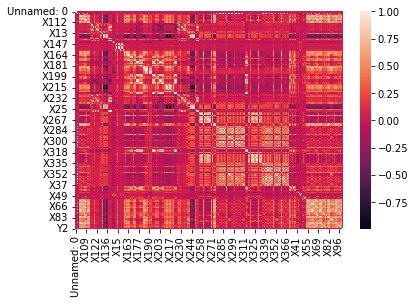

In [15]:
#examine correlation heat map
sns.heatmap(FinalDF_3.corr())

From the correlation heatmap, it shows the covariance between some variables. The correlation matrix indicates that most variables have a correlation between -0.50 and 0.50. 
There are too many variables to underpin major dependent variables.

In [16]:
#check for "999999" values
FinalDF_3[FinalDF_3.eq("999999").any(1)]

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2


In [17]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df3_Y1 = FinalDF_3.sample(frac = 0.5)
df3_Y2 = FinalDF_3.sample(frac = 0.5)
print("Shape of new dataframes - {} , {}".format(df3_Y1.shape, df3_Y2.shape))

Shape of new dataframes - (112500, 383) , (112500, 383)


In [29]:
#create Y1 dataframe after quality check and remove NaN values
New_Y1_Part3 = df3_Y1.drop(index=[row for row in df3_Y1.index if 0.9999 > df3_Y1.loc[row, 'Q1']])
New_Y1_Part3 = New_Y1_Part3.dropna()
New_Y1_Part3.head()

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
133114,20614,55715000,SPX,cme,1.0,1.0,-0.131553,-0.163809,0.965066,0.615347,...,-0.048775,0.361425,0.236481,1.027705,0.699744,-0.251117,0.310978,0.249719,-27.299664,-23.976046
119678,7178,42279000,SPX,cme,1.0,1.0,1.191034,-0.471260,-1.615237,-0.988288,...,-0.698117,-0.618078,-0.808331,-2.675172,-1.775085,-1.030061,-1.117244,-0.330890,-11.213350,-13.011437
206170,3670,38771000,SPX,cme,1.0,1.0,0.383946,-1.501467,-1.087114,-0.901533,...,-0.754502,-0.722818,-0.577554,-1.992164,-2.337767,-1.258908,-1.765495,-0.328617,-6.849081,-1.904933
90567,567,35668000,SPX,cme,1.0,1.0,0.776038,-2.144850,-0.817721,-0.434410,...,-0.730107,-0.417691,-0.146319,-0.955676,0.008214,-2.627154,-1.852276,0.074722,-4.447975,-10.339102
163638,6138,41239000,SPX,cme,1.0,1.0,-0.843106,0.410059,0.597852,0.519127,...,0.351497,0.544179,0.169256,0.924637,0.665380,0.471524,0.614170,0.113677,2.654720,0.000000


In [36]:
#create Y2 dataframe after quality check and removing NaN values
New_Y2_Part3 = df3_Y2.drop(index=[row for row in df3_Y2.index if 0.9999 > df3_Y2.loc[row, 'Q2']])
New_Y2_Part3 = New_Y2_Part3.dropna()
New_Y2_Part3.head()

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
158908,1408,36509000,SPX,cme,1.0,1.0,0.153055,-0.271711,-0.112857,-0.228773,...,-0.001247,-0.209974,1.324702,1.906361,0.426873,0.225693,0.313612,0.121295,-3.291964,-4.321381
184276,4276,39377000,SPX,cme,1.0,1.0,-0.713813,0.323342,0.556586,0.443286,...,-0.323560,-0.064383,-0.037161,0.688333,0.864089,-0.207583,0.316912,-0.061927,8.865550,12.886165
171668,14168,49269000,SPX,cme,1.0,1.0,0.590593,-0.324954,-0.263978,-0.311660,...,-0.089777,0.064719,0.501526,-0.040618,-0.061578,-0.427040,-0.197074,0.182247,-5.296435,-5.631240
169392,11892,46993000,SPX,cme,1.0,1.0,-0.622151,0.621927,0.136568,0.282691,...,0.164897,0.278829,-0.225602,0.136063,0.410565,0.220450,0.605869,-0.009974,-5.308032,-5.323136
27653,5153,40254000,SPX,cme,1.0,1.0,-0.552949,1.452187,-0.075850,-0.280071,...,0.173117,0.056197,-0.530061,0.238927,-0.180801,1.033263,1.006106,-0.777197,-0.604796,-6.710747


In [30]:
#drop columns not used for calibration for Y1
New_Y1_Part3 = New_Y1_Part3.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)
New_Y1_Part3.head()

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
133114,-0.131553,-0.163809,0.965066,0.615347,-0.152419,0.356658,0.226396,0.782263,0.563997,-0.287491,...,0.578527,-0.048775,0.361425,0.236481,1.027705,0.699744,-0.251117,0.310978,0.249719,-27.299664
119678,1.191034,-0.471260,-1.615237,-0.988288,-0.779324,-0.720059,-0.568636,-1.801609,-1.184278,-0.974409,...,-0.878543,-0.698117,-0.618078,-0.808331,-2.675172,-1.775085,-1.030061,-1.117244,-0.330890,-11.213350
206170,0.383946,-1.501467,-1.087114,-0.901533,-0.869848,-0.828744,-0.464337,-1.535484,-1.284058,-0.824545,...,-0.774217,-0.754502,-0.722818,-0.577554,-1.992164,-2.337767,-1.258908,-1.765495,-0.328617,-6.849081
90567,0.776038,-2.144850,-0.817721,-0.434410,-0.814305,-0.507877,-0.065344,-0.691846,-0.473321,-1.335275,...,-0.339413,-0.730107,-0.417691,-0.146319,-0.955676,0.008214,-2.627154,-1.852276,0.074722,-4.447975
163638,-0.843106,0.410059,0.597852,0.519127,0.349254,0.539649,0.221893,0.767889,0.588933,0.330715,...,0.522422,0.351497,0.544179,0.169256,0.924637,0.665380,0.471524,0.614170,0.113677,2.654720


In [37]:
#drop columns not used for calibration for Y2
New_Y2_Part3 = New_Y2_Part3.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)
New_Y2_Part3.head()

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y2
158908,0.153055,-0.271711,-0.112857,-0.228773,-0.027746,-0.246622,0.460027,0.490840,0.238533,0.126222,...,-0.277012,-0.001247,-0.209974,1.324702,1.906361,0.426873,0.225693,0.313612,0.121295,-4.321381
184276,-0.713813,0.323342,0.556586,0.443286,-0.390860,-0.074628,-0.113049,0.743247,0.582222,-0.323578,...,0.371734,-0.323560,-0.064383,-0.037161,0.688333,0.864089,-0.207583,0.316912,-0.061927,12.886165
171668,0.590593,-0.324954,-0.263978,-0.311660,-0.135131,0.048039,0.371057,-0.072383,-0.164116,-0.255518,...,-0.312028,-0.089777,0.064719,0.501526,-0.040618,-0.061578,-0.427040,-0.197074,0.182247,-5.631240
169392,-0.622151,0.621927,0.136568,0.282691,0.168263,0.294871,-0.143866,0.208447,0.485546,0.296718,...,0.285366,0.164897,0.278829,-0.225602,0.136063,0.410565,0.220450,0.605869,-0.009974,-5.323136
27653,-0.552949,1.452187,-0.075850,-0.280071,0.243946,0.140881,-0.543535,-0.065192,-0.163889,0.806387,...,-0.268664,0.173117,0.056197,-0.530061,0.238927,-0.180801,1.033263,1.006106,-0.777197,-6.710747


# 2.3 Prepare Sample

We select x variables from entire day sample obtained from in-sample. We use the ANOVA 5 feature selection.

In [38]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y2
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)

In [39]:
#assign variables names for Y1 
Y1 = New_Y1["Y1"]
x1 = New_Y1.drop(["Y1"], axis =1)

Y1 = Y1.sample(frac = 0.1)
x1 = x1.sample(frac = 0.1)

#assign variables names for Y2 
Y2 = New_Y2["Y2"]
x2 = New_Y2.drop(["Y2"], axis =1)

Y2 = Y2.sample(frac = 0.1)
x2 = x2.sample(frac = 0.1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, x1.shape, x2.shape))

Shape of new dataframes - (104566,) , (104602,), (104566, 375), (104602, 375)


In [51]:
#assign variables names for x1 
Anova_x1 = New_Y1[["X114", "X115", "X126", "X288", "X303"]]
#fraction to match sample size for in-sample and out-of-sample for train-test split
Anova_x1 = Anova_x1.iloc[:103497]

#assign variables names for x2 
Anova_x2 = New_Y2[["X123", "X124", "X125", "X128", "X129"]]
#fraction to match sample size for in-sample and out-of-sample for train-test split
Anova_x2 = Anova_x2.iloc[:103369]

In [52]:
print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, Anova_x1.shape, Anova_x2.shape))

Shape of new dataframes - (104566,) , (104602,), (103497, 5), (103369, 5)


We set up test for y out-of-sample.

In [53]:
#assign variables names for Y1 
Y1_Part3 = New_Y1_Part3["Y1"]
x1_Part3 = New_Y1_Part3.drop(["Y1"], axis =1)

#assign variables names for Y1 
Y2_Part3 = New_Y2_Part3["Y2"]
x2_Part3 = New_Y2_Part3.drop(["Y2"], axis =1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1_Part3.shape, Y2_Part3.shape, x1_Part3.shape, x2_Part3.shape))


Shape of new dataframes - (103497,) , (103369,), (103497, 375), (103369, 375)


# 2.4 Lasso Regression Y1

In [47]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(Anova_x1, Y1_Part3, test_size=0.33, random_state=42, shuffle=True)

In [48]:
#Y1
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))


14.984022577149474
5.758863584004459e-06
14.769373689658632
-3.560936807156523e-05
Root Mean Squared Error  Y1: 14.769373689658632


In [49]:
#print coefficients
print(list(zip(model_lasso.coef_, Anova_x1)))

[(0.048748839244357835, 'X114'), (0.0, 'X115'), (0.0, 'X126'), (0.0, 'X288'), (-0.0, 'X303')]


# 2.5 Lasso Regression Y2

In [54]:
#for Y2
x_train, x_test, y_train, y_test = train_test_split(Anova_x2, Y2_Part3, test_size=0.33, random_state=42, shuffle=True)

In [55]:
#Y2
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

lasso_model=model_lasso.fit(x_train, y_train) 

17.87976277268996
0.00017646387460856783
17.841812729483756
-8.929676805502496e-05
Root Mean Squared Error  Y2: 17.841812729483756


In [56]:
#print coefficients
print(list(zip(model_lasso.coef_, Anova_x2)))

[(0.09683885418825815, 'X123'), (0.0, 'X124'), (0.1463334217186909, 'X125'), (-0.1464578625469074, 'X128'), (-0.0, 'X129')]


# Summary out-of-sample

The RMSE slighlty increased in the out-of-sample calibration. The results are:
    
| Algorithm RMSE | Y1 | Y2 |
|:--------:|:--------:|:--------:|
|  Lasso |  14.90  |  18.02   |

    

The model prediction only selected the most informational variables per calibration.

The calibration for Y1 is $ Y_{1} = 0.04874X_{114}$.

The calibration for Y2 is $ Y_{2} = 0.09683X_{123} + 0.14633X_{125} - 0.14645X_{128}$.

# DISREGARD SECTION BELOW: NOT SUFFICIENT MEMORY CAPACITY TO RUN 2 METADATA

# 3. Disregarded out-of-sample

# 3.1 Data cleaning

In [292]:
#examine names of all parquet files in directory
path_dir = 'C://Users//CanBec//Desktop//qr_takehome_part2'
for files in os.listdir(path_dir):
    print(files)

QR_TAKEHOME_20220606.csv.parquet
QR_TAKEHOME_20220607.csv.parquet
QR_TAKEHOME_20220608.csv.parquet
QR_TAKEHOME_20220609.csv.parquet
QR_TAKEHOME_20220610.csv.parquet
QR_TAKEHOME_20220613.csv.parquet
QR_TAKEHOME_20220614.csv.parquet
QR_TAKEHOME_20220615.csv.parquet
QR_TAKEHOME_20220616.csv.parquet
QR_TAKEHOME_20220617.csv.parquet
QR_TAKEHOME_20220621.csv.parquet
QR_TAKEHOME_20220622.csv.parquet
QR_TAKEHOME_20220623.csv.parquet
QR_TAKEHOME_20220624.csv.parquet
QR_TAKEHOME_20220627.csv.parquet
QR_TAKEHOME_20220628.csv.parquet
QR_TAKEHOME_20220629.csv.parquet
QR_TAKEHOME_20220630.csv.parquet
QR_TAKEHOME_20220701.csv.parquet
QR_TAKEHOME_20220705.csv.parquet
QR_TAKEHOME_20220706.csv.parquet
QR_TAKEHOME_20220707.csv.parquet
QR_TAKEHOME_20220708.csv.parquet
QR_TAKEHOME_20220711.csv.parquet
QR_TAKEHOME_20220712.csv.parquet
QR_TAKEHOME_20220713.csv.parquet
QR_TAKEHOME_20220714.csv.parquet
QR_TAKEHOME_20220715.csv.parquet
QR_TAKEHOME_20220718.csv.parquet
QR_TAKEHOME_20220719.csv.parquet
QR_TAKEHOM

# Metadata Concatenation

In [414]:
#concatenante all parquet files into 1 csv file
data_dir = Path('C://Users//CanBec//Desktop//qr_takehome_part2')
for i, parquet_path in enumerate(data_dir.glob('*.parquet')):
    df = pd.read_parquet(parquet_path)
    write_header = i == 0 # write header only on the 0th file
    write_mode = 'w' if i == 0 else 'a' # 'write' mode for 0th file, 'append' otherwise
    df.to_csv('csv_file_part2.csv', mode=write_mode, header=write_header)

In [4]:
# get the start time
st = time.process_time()

#rename concatenated csv file into new dataframe
FinalDF_2 = pd.read_csv('csv_file_part2.csv')
print(FinalDF_2.count())


# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

Unnamed: 0    2250000
time          2250000
sym           2250000
exch          2250000
Q1            2250000
               ...   
X97           2149260
X98           2157741
X99           2244446
Y1            2250000
Y2            2250000
Length: 383, dtype: int64
Execution time: 3.33515625 minutes


In [3]:
#technical information about dataframe
FinalDF_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250000 entries, 0 to 2249999
Columns: 383 entries, Unnamed: 0 to Y2
dtypes: float64(379), int64(2), object(2)
memory usage: 6.4+ GB


In [4]:
#Analyzing memory print for attributes
FinalDF_2.memory_usage(deep=True) 

Index               128
Unnamed: 0     18000000
time           18000000
sym           135000000
exch          135000000
                ...    
X97            18000000
X98            18000000
X99            18000000
Y1             18000000
Y2             18000000
Length: 384, dtype: int64

# 3.2 Data Exploration

Execution time: 19.37421875 minutes


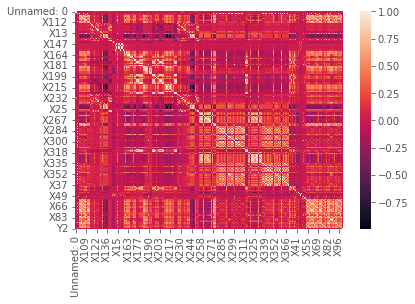

In [432]:
## get the start time
st = time.process_time()

#examine correlation heat map
sns.heatmap(FinalDF_2.corr())

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

From the correlation heatmap, it shows the covariance between some variables. The correlation matrix indicates that most
variables have a correlation between -0.50 and 0.50. There are too many variables to underpin major dependent variables.

In [5]:
# get the start time
st = time.process_time()

#check for "999999" values
FinalDF_2[FinalDF_2.eq("999999").any(1)]
print(len(FinalDF_2[FinalDF_2.eq("999999").any(1)]))

# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

0
Execution time: 0.04140625 minutes


In [6]:
#total length of dataframe in number of rows
FinalDF_2.shape[0]

2250000

# Optimize memory use

# Creation of 2 datasets for calibration

To boost memory capacity and speed up execution, I downcast variables.

In [ ]:
# get the start time
st = time.process_time()

#downcast to limit memory consumption for approx half the variables
#sym and exch cannot be downcasted
FinalDF_2["time"] = pd.to_numeric(FinalDF_2["time"], downcast="integer")
FinalDF_2["Q1"] = pd.to_numeric(FinalDF_2["Q1"], downcast="integer")
FinalDF_2["Q2"] = pd.to_numeric(FinalDF_2["Q2"], downcast="integer")
FinalDF_2["X1"] = pd.to_numeric(FinalDF_2["X1"], downcast="integer")
FinalDF_2["X2"] = pd.to_numeric(FinalDF_2["X2"], downcast="integer")
FinalDF_2["X3"] = pd.to_numeric(FinalDF_2["X3"], downcast="integer")
FinalDF_2["X4"] = pd.to_numeric(FinalDF_2["X4"], downcast="integer")
FinalDF_2["X5"] = pd.to_numeric(FinalDF_2["X5"], downcast="integer")
FinalDF_2["X6"] = pd.to_numeric(FinalDF_2["X6"], downcast="integer")
FinalDF_2["X7"] = pd.to_numeric(FinalDF_2["X7"], downcast="integer")
FinalDF_2["X8"] = pd.to_numeric(FinalDF_2["X8"], downcast="integer")
FinalDF_2["X9"] = pd.to_numeric(FinalDF_2["X9"], downcast="integer")
FinalDF_2["X10"] = pd.to_numeric(FinalDF_2["X10"], downcast="integer")
FinalDF_2["X20"] = pd.to_numeric(FinalDF_2["X20"], downcast="integer")
FinalDF_2["X21"] = pd.to_numeric(FinalDF_2["X21"], downcast="integer")
FinalDF_2["X22"] = pd.to_numeric(FinalDF_2["X22"], downcast="integer")
FinalDF_2["X23"] = pd.to_numeric(FinalDF_2["X23"], downcast="integer")
FinalDF_2["X24"] = pd.to_numeric(FinalDF_2["X24"], downcast="integer")
FinalDF_2["X25"] = pd.to_numeric(FinalDF_2["X25"], downcast="integer")
FinalDF_2["X26"] = pd.to_numeric(FinalDF_2["X26"], downcast="integer")
FinalDF_2["X27"] = pd.to_numeric(FinalDF_2["X27"], downcast="integer")
FinalDF_2["X28"] = pd.to_numeric(FinalDF_2["X28"], downcast="integer")
FinalDF_2["X29"] = pd.to_numeric(FinalDF_2["X29"], downcast="integer")
FinalDF_2["X50"] = pd.to_numeric(FinalDF_2["X50"], downcast="integer")
FinalDF_2["X51"] = pd.to_numeric(FinalDF_2["X51"], downcast="integer")
FinalDF_2["X52"] = pd.to_numeric(FinalDF_2["X52"], downcast="integer")
FinalDF_2["X53"] = pd.to_numeric(FinalDF_2["X53"], downcast="integer")
FinalDF_2["X54"] = pd.to_numeric(FinalDF_2["X54"], downcast="integer")
FinalDF_2["X55"] = pd.to_numeric(FinalDF_2["X55"], downcast="integer")
FinalDF_2["X56"] = pd.to_numeric(FinalDF_2["X56"], downcast="integer")
FinalDF_2["X57"] = pd.to_numeric(FinalDF_2["X57"], downcast="integer")
FinalDF_2["X58"] = pd.to_numeric(FinalDF_2["X58"], downcast="integer")
FinalDF_2["X59"] = pd.to_numeric(FinalDF_2["X59"], downcast="integer")
FinalDF_2["X80"] = pd.to_numeric(FinalDF_2["X80"], downcast="integer")
FinalDF_2["X81"] = pd.to_numeric(FinalDF_2["X81"], downcast="integer")
FinalDF_2["X82"] = pd.to_numeric(FinalDF_2["X82"], downcast="integer")
FinalDF_2["X83"] = pd.to_numeric(FinalDF_2["X83"], downcast="integer")
FinalDF_2["X84"] = pd.to_numeric(FinalDF_2["X84"], downcast="integer")
FinalDF_2["X85"] = pd.to_numeric(FinalDF_2["X85"], downcast="integer")
FinalDF_2["X86"] = pd.to_numeric(FinalDF_2["X86"], downcast="integer")
FinalDF_2["X87"] = pd.to_numeric(FinalDF_2["X87"], downcast="integer")
FinalDF_2["X88"] = pd.to_numeric(FinalDF_2["X88"], downcast="integer")
FinalDF_2["X89"] = pd.to_numeric(FinalDF_2["X89"], downcast="integer")
FinalDF_2["X110"] = pd.to_numeric(FinalDF_2["X110"], downcast="integer")
FinalDF_2["X111"] = pd.to_numeric(FinalDF_2["X111"], downcast="integer")
FinalDF_2["X112"] = pd.to_numeric(FinalDF_2["X112"], downcast="integer")
FinalDF_2["X113"] = pd.to_numeric(FinalDF_2["X113"], downcast="integer")
FinalDF_2["X114"] = pd.to_numeric(FinalDF_2["X114"], downcast="integer")
FinalDF_2["X115"] = pd.to_numeric(FinalDF_2["X115"], downcast="integer")
FinalDF_2["X116"] = pd.to_numeric(FinalDF_2["X116"], downcast="integer")
FinalDF_2["X117"] = pd.to_numeric(FinalDF_2["X117"], downcast="integer")
FinalDF_2["X118"] = pd.to_numeric(FinalDF_2["X118"], downcast="integer")
FinalDF_2["X119"] = pd.to_numeric(FinalDF_2["X119"], downcast="integer")
FinalDF_2["X140"] = pd.to_numeric(FinalDF_2["X140"], downcast="integer")
FinalDF_2["X141"] = pd.to_numeric(FinalDF_2["X141"], downcast="integer")
FinalDF_2["X142"] = pd.to_numeric(FinalDF_2["X142"], downcast="integer")
FinalDF_2["X143"] = pd.to_numeric(FinalDF_2["X143"], downcast="integer")
FinalDF_2["X144"] = pd.to_numeric(FinalDF_2["X144"], downcast="integer")
FinalDF_2["X145"] = pd.to_numeric(FinalDF_2["X145"], downcast="integer")
FinalDF_2["X146"] = pd.to_numeric(FinalDF_2["X146"], downcast="integer")
FinalDF_2["X147"] = pd.to_numeric(FinalDF_2["X147"], downcast="integer")
FinalDF_2["X148"] = pd.to_numeric(FinalDF_2["X148"], downcast="integer")
FinalDF_2["X149"] = pd.to_numeric(FinalDF_2["X149"], downcast="integer")
FinalDF_2["X170"] = pd.to_numeric(FinalDF_2["X170"], downcast="integer")
FinalDF_2["X171"] = pd.to_numeric(FinalDF_2["X171"], downcast="integer")
FinalDF_2["X172"] = pd.to_numeric(FinalDF_2["X172"], downcast="integer")
FinalDF_2["X173"] = pd.to_numeric(FinalDF_2["X173"], downcast="integer")
FinalDF_2["X174"] = pd.to_numeric(FinalDF_2["X174"], downcast="integer")
FinalDF_2["X175"] = pd.to_numeric(FinalDF_2["X175"], downcast="integer")
FinalDF_2["X176"] = pd.to_numeric(FinalDF_2["X176"], downcast="integer")
FinalDF_2["X177"] = pd.to_numeric(FinalDF_2["X177"], downcast="integer")
FinalDF_2["X178"] = pd.to_numeric(FinalDF_2["X178"], downcast="integer")
FinalDF_2["X179"] = pd.to_numeric(FinalDF_2["X179"], downcast="integer")
FinalDF_2["X200"] = pd.to_numeric(FinalDF_2["X200"], downcast="integer")
FinalDF_2["X201"] = pd.to_numeric(FinalDF_2["X201"], downcast="integer")
FinalDF_2["X202"] = pd.to_numeric(FinalDF_2["X202"], downcast="integer")
FinalDF_2["X203"] = pd.to_numeric(FinalDF_2["X203"], downcast="integer")
FinalDF_2["X204"] = pd.to_numeric(FinalDF_2["X204"], downcast="integer")
FinalDF_2["X205"] = pd.to_numeric(FinalDF_2["X205"], downcast="integer")
FinalDF_2["X206"] = pd.to_numeric(FinalDF_2["X206"], downcast="integer")
FinalDF_2["X207"] = pd.to_numeric(FinalDF_2["X207"], downcast="integer")
FinalDF_2["X208"] = pd.to_numeric(FinalDF_2["X208"], downcast="integer")
FinalDF_2["X209"] = pd.to_numeric(FinalDF_2["X209"], downcast="integer")
FinalDF_2["X230"] = pd.to_numeric(FinalDF_2["X230"], downcast="integer")
FinalDF_2["X231"] = pd.to_numeric(FinalDF_2["X231"], downcast="integer")
FinalDF_2["X232"] = pd.to_numeric(FinalDF_2["X232"], downcast="integer")
FinalDF_2["X233"] = pd.to_numeric(FinalDF_2["X233"], downcast="integer")
FinalDF_2["X234"] = pd.to_numeric(FinalDF_2["X234"], downcast="integer")
FinalDF_2["X235"] = pd.to_numeric(FinalDF_2["X235"], downcast="integer")
FinalDF_2["X236"] = pd.to_numeric(FinalDF_2["X236"], downcast="integer")
FinalDF_2["X237"] = pd.to_numeric(FinalDF_2["X237"], downcast="integer")
FinalDF_2["X238"] = pd.to_numeric(FinalDF_2["X238"], downcast="integer")
FinalDF_2["X239"] = pd.to_numeric(FinalDF_2["X239"], downcast="integer")
FinalDF_2["X260"] = pd.to_numeric(FinalDF_2["X260"], downcast="integer")
FinalDF_2["X261"] = pd.to_numeric(FinalDF_2["X261"], downcast="integer")
FinalDF_2["X262"] = pd.to_numeric(FinalDF_2["X262"], downcast="integer")
FinalDF_2["X263"] = pd.to_numeric(FinalDF_2["X263"], downcast="integer")
FinalDF_2["X264"] = pd.to_numeric(FinalDF_2["X264"], downcast="integer")
FinalDF_2["X265"] = pd.to_numeric(FinalDF_2["X265"], downcast="integer")
FinalDF_2["X266"] = pd.to_numeric(FinalDF_2["X266"], downcast="integer")
FinalDF_2["X267"] = pd.to_numeric(FinalDF_2["X267"], downcast="integer")
FinalDF_2["X268"] = pd.to_numeric(FinalDF_2["X268"], downcast="integer")
FinalDF_2["X269"] = pd.to_numeric(FinalDF_2["X269"], downcast="integer")
FinalDF_2["X280"] = pd.to_numeric(FinalDF_2["X280"], downcast="integer")
FinalDF_2["X281"] = pd.to_numeric(FinalDF_2["X281"], downcast="integer")
FinalDF_2["X282"] = pd.to_numeric(FinalDF_2["X282"], downcast="integer")
FinalDF_2["X283"] = pd.to_numeric(FinalDF_2["X283"], downcast="integer")
FinalDF_2["X284"] = pd.to_numeric(FinalDF_2["X284"], downcast="integer")
FinalDF_2["X285"] = pd.to_numeric(FinalDF_2["X285"], downcast="integer")
FinalDF_2["X286"] = pd.to_numeric(FinalDF_2["X286"], downcast="integer")
FinalDF_2["X287"] = pd.to_numeric(FinalDF_2["X287"], downcast="integer")
FinalDF_2["X288"] = pd.to_numeric(FinalDF_2["X288"], downcast="integer")
FinalDF_2["X289"] = pd.to_numeric(FinalDF_2["X289"], downcast="integer")
FinalDF_2["X310"] = pd.to_numeric(FinalDF_2["X310"], downcast="integer")
FinalDF_2["X311"] = pd.to_numeric(FinalDF_2["X311"], downcast="integer")
FinalDF_2["X312"] = pd.to_numeric(FinalDF_2["X312"], downcast="integer")
FinalDF_2["X313"] = pd.to_numeric(FinalDF_2["X313"], downcast="integer")
FinalDF_2["X314"] = pd.to_numeric(FinalDF_2["X314"], downcast="integer")
FinalDF_2["X315"] = pd.to_numeric(FinalDF_2["X315"], downcast="integer")
FinalDF_2["X316"] = pd.to_numeric(FinalDF_2["X316"], downcast="integer")
FinalDF_2["X317"] = pd.to_numeric(FinalDF_2["X317"], downcast="integer")
FinalDF_2["X318"] = pd.to_numeric(FinalDF_2["X318"], downcast="integer")
FinalDF_2["X319"] = pd.to_numeric(FinalDF_2["X319"], downcast="integer")
FinalDF_2["X320"] = pd.to_numeric(FinalDF_2["X320"], downcast="integer")
FinalDF_2["X321"] = pd.to_numeric(FinalDF_2["X321"], downcast="integer")
FinalDF_2["X322"] = pd.to_numeric(FinalDF_2["X322"], downcast="integer")
FinalDF_2["X323"] = pd.to_numeric(FinalDF_2["X323"], downcast="integer")
FinalDF_2["X324"] = pd.to_numeric(FinalDF_2["X324"], downcast="integer")
FinalDF_2["X325"] = pd.to_numeric(FinalDF_2["X325"], downcast="integer")
FinalDF_2["X326"] = pd.to_numeric(FinalDF_2["X326"], downcast="integer")
FinalDF_2["X327"] = pd.to_numeric(FinalDF_2["X327"], downcast="integer")
FinalDF_2["X328"] = pd.to_numeric(FinalDF_2["X328"], downcast="integer")
FinalDF_2["X329"] = pd.to_numeric(FinalDF_2["X329"], downcast="integer")
FinalDF_2["X340"] = pd.to_numeric(FinalDF_2["X340"], downcast="integer")
FinalDF_2["X341"] = pd.to_numeric(FinalDF_2["X341"], downcast="integer")
FinalDF_2["X342"] = pd.to_numeric(FinalDF_2["X342"], downcast="integer")
FinalDF_2["X343"] = pd.to_numeric(FinalDF_2["X343"], downcast="integer")
FinalDF_2["X344"] = pd.to_numeric(FinalDF_2["X344"], downcast="integer")
FinalDF_2["X345"] = pd.to_numeric(FinalDF_2["X345"], downcast="integer")
FinalDF_2["X346"] = pd.to_numeric(FinalDF_2["X346"], downcast="integer")
FinalDF_2["X347"] = pd.to_numeric(FinalDF_2["X347"], downcast="integer")
FinalDF_2["X348"] = pd.to_numeric(FinalDF_2["X348"], downcast="integer")
FinalDF_2["X349"] = pd.to_numeric(FinalDF_2["X349"], downcast="integer")
FinalDF_2["X360"] = pd.to_numeric(FinalDF_2["X360"], downcast="integer")
FinalDF_2["X361"] = pd.to_numeric(FinalDF_2["X361"], downcast="integer")
FinalDF_2["X362"] = pd.to_numeric(FinalDF_2["X362"], downcast="integer")
FinalDF_2["X363"] = pd.to_numeric(FinalDF_2["X363"], downcast="integer")
FinalDF_2["X364"] = pd.to_numeric(FinalDF_2["X364"], downcast="integer")
FinalDF_2["X365"] = pd.to_numeric(FinalDF_2["X365"], downcast="integer")
FinalDF_2["X366"] = pd.to_numeric(FinalDF_2["X366"], downcast="integer")
FinalDF_2["X367"] = pd.to_numeric(FinalDF_2["X367"], downcast="integer")
FinalDF_2["X368"] = pd.to_numeric(FinalDF_2["X368"], downcast="integer")
FinalDF_2["X369"] = pd.to_numeric(FinalDF_2["X369"], downcast="integer")
FinalDF_2["X370"] = pd.to_numeric(FinalDF_2["X370"], downcast="integer")
FinalDF_2["X371"] = pd.to_numeric(FinalDF_2["X371"], downcast="integer")
FinalDF_2["X372"] = pd.to_numeric(FinalDF_2["X372"], downcast="integer")
FinalDF_2["X373"] = pd.to_numeric(FinalDF_2["X373"], downcast="integer")

FinalDF.dtypes
FinalDF.memory_usage(deep=True) 



# get the end time
et = time.process_time()
# get execution time
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

In [6]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df2_Y1 = FinalDF_2.sample(frac = 0.5)
df2_Y2 = FinalDF_2.sample(frac = 0.5)
print("Shape of new dataframes - {} , {}".format(df2_Y1.shape, df2_Y2.shape))
print(len(df2_Y2))
print(len(df2_Y1))

Shape of new dataframes - (1125000, 383) , (1125000, 383)
1125000
1125000


In [5]:
# find rows when Q1 < 0.9999 from df_Y1 for calibration
Remove_from_Y1_Part2 = df2_Y1.loc[df2_Y1["Q1"] < 0.9999]
display(Remove_from_Y1_Part2)
print(len(Remove_from_Y1_Part2))

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
571851,9351,44452000,SPX,cme,0.15,1.00,0.067492,NaN,0.186708,0.177626,...,NaN,NaN,0.259561,0.414169,0.465092,NaN,NaN,0.121360,5.911912,8.513446
579914,17414,52515000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.232395,NaN,NaN,NaN,NaN,-0.346894,0.653488,0.000000
1895045,5045,40146000,SPX,cme,0.15,1.00,-0.500839,NaN,0.307347,0.314242,...,NaN,NaN,-0.170453,0.132069,-0.103493,NaN,NaN,-0.033830,18.653494,17.820425
1608636,11136,46237000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.646977,-1.373714
455141,5141,40242000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,0.381585,NaN,NaN,NaN,NaN,0.582528,20.954065,28.735023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466207,3707,38808000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,0.956794,NaN,NaN,NaN,NaN,-0.256191,-7.508212,-9.441720
242435,17435,52536000,SPX,cme,0.15,1.00,0.667711,NaN,0.026780,-0.131722,...,NaN,NaN,0.403536,0.283167,-0.288344,NaN,NaN,0.255424,-3.313562,-6.463567
2057277,9777,44878000,SPX,cme,0.15,1.00,0.602650,NaN,-0.923375,-0.586247,...,NaN,NaN,-0.303876,-0.754130,-0.569219,NaN,NaN,-0.540701,8.772818,15.018549
1125880,880,35981000,SPX,cme,0.15,1.00,1.316541,NaN,-0.155203,-0.034729,...,NaN,NaN,-1.288832,-0.073975,-1.614038,NaN,NaN,-0.167541,-3.504775,-5.817551


50532


In [7]:
#create Y1 dataframe after quality check and remove NaN values
New_Y1_Part2 = df2_Y1.drop(index=[row for row in df2_Y1.index if 0.9999 > df2_Y1.loc[row, 'Q1']])
New_Y1_Part2 = New_Y1_Part2.dropna()
display(New_Y1_Part2)
print(len(New_Y1_Part2))


,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
248684,1184,36285000,SPX,cme,1.0,1.0,-0.774387,0.458319,1.011804,0.923938,...,0.844117,0.946516,1.548381,2.113957,1.757183,1.365846,1.694637,0.497435,11.997201,13.387893
485335,12835,47936000,SPX,cme,1.0,1.0,-0.368534,-0.013466,0.465885,0.226762,...,0.392037,0.230106,-0.589175,0.040932,-0.150889,0.093410,-0.031074,-0.151531,1.927339,8.482817
601592,16592,51693000,SPX,cme,1.0,1.0,-1.249529,-0.023728,0.321534,0.335546,...,0.616990,0.566652,0.421824,0.732048,1.109665,0.873865,0.727619,0.098467,2.639828,2.331842
1901116,11116,46217000,SPX,cme,1.0,1.0,-0.136546,-0.361159,-0.187336,-0.250066,...,-0.185476,-0.121712,0.035537,-0.239243,-0.136790,-0.305493,-0.269650,0.034479,-3.461286,3.434774
263846,16346,51447000,SPX,cme,1.0,1.0,-0.201442,-0.445814,-0.344282,-0.455428,...,-0.372181,-0.344572,0.414710,-0.385124,-0.574018,-0.646451,-0.556070,0.037615,-29.569275,-30.304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587490,12490,47591000,SPX,cme,1.0,1.0,-0.036009,-0.281262,-0.138988,0.085392,...,-0.065625,-0.125830,0.035795,0.172008,0.386219,0.172925,-0.195091,0.077825,8.219785,6.187098
316546,1546,36647000,SPX,cme,1.0,1.0,0.730200,-0.822410,0.372200,0.168542,...,0.653447,0.603433,-0.909684,0.184671,-0.661651,0.821531,-1.035202,-0.034528,-4.482439,-11.603933
1836011,13511,48612000,SPX,cme,1.0,1.0,-0.079474,-0.881221,-0.586282,-0.246135,...,-0.466441,-0.459260,-0.438395,-0.924173,-0.451965,-0.649045,-0.954112,-0.330721,-10.549566,-8.194424
2090814,20814,55915000,SPX,cme,1.0,1.0,0.003697,-0.495654,-0.233404,-0.053263,...,-0.163050,-0.152153,0.311196,0.082098,0.375405,-0.119893,-0.091255,-0.137311,6.814078,7.455942


1046814


We created a cleaned dataset to examine Y1 after Q1 quality check and removing NaN values. 


In [11]:
# find rows when Q2 < 0.9999 from df_Y2 for calibration
Remove_from_Y2_Part2 = df2_Y2.loc[df2_Y2["Q2"] < 0.9999]
display(Remove_from_Y2_Part2)
print(len(Remove_from_Y2_Part2))

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
2227243,22243,57344000,SPX,cme,1.00,0.21,1.973640,0.327242,NaN,-0.339565,...,-0.181123,-0.117836,0.027374,NaN,-1.324835,0.302059,-0.286318,-0.283795,-4.472986,-9.055530
2159612,22112,57213000,SPX,cme,1.00,0.12,0.792617,0.443674,NaN,0.186952,...,0.554339,0.308583,-0.053135,NaN,-0.147263,0.800958,0.332142,0.136656,-8.396034,-6.403825
157957,457,35558000,SPX,cme,1.00,0.21,-0.255333,-0.659858,NaN,0.196259,...,-1.024990,-0.816757,0.094572,NaN,-0.740629,-1.524349,-0.976176,-0.274182,0.659652,-7.806571
1464870,2370,37471000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,0.745775,NaN,NaN,NaN,NaN,-0.303413,7.544086,5.615454
173079,15579,50680000,SPX,cme,0.15,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.984420,14.074211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259687,22187,57288000,SPX,cme,1.00,0.12,-0.430110,0.296303,NaN,0.295135,...,0.099858,0.080594,0.122326,NaN,0.853754,0.744173,0.588126,0.049197,-16.272411,-18.627546
944728,22228,57329000,SPX,cme,1.00,0.21,1.077712,0.662763,NaN,-0.224199,...,-0.004144,0.270396,0.080107,NaN,-0.539029,0.348233,0.439435,0.104533,8.434497,15.213553
67184,22184,57285000,SPX,cme,1.00,0.21,-0.128832,-0.789961,NaN,-0.514913,...,-0.576472,-0.690724,0.006888,NaN,-0.130174,-0.421134,-0.746042,-0.081002,3.040160,6.744292
1844897,22397,57498000,SPX,cme,1.00,0.12,0.679216,-0.059308,NaN,-0.389172,...,0.125307,-0.160685,0.516247,NaN,-0.413682,0.311610,-0.011175,0.135371,10.545395,12.907250


48583


In [8]:
#create Y2 dataframe after quality check and removing NaN values
New_Y2_Part2 = df2_Y2.drop(index=[row for row in df2_Y2.index if 0.9999 > df2_Y2.loc[row, 'Q2']])
New_Y2_Part2 = New_Y2_Part2.dropna()
display(New_Y2_Part2)
print(len(New_Y2_Part2))

,Unnamed: 0,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
1716677,6677,41778000,SPX,cme,1.0,1.0,-0.169292,-0.464008,0.638391,0.666443,...,0.103309,0.383772,0.494813,0.341074,0.463465,-0.449794,0.063130,0.333819,-8.769267,-10.535558
1039540,4540,39641000,SPX,cme,1.0,1.0,0.362562,-0.715961,0.167668,0.059338,...,-0.606210,-0.377887,-0.595328,-0.447405,-0.568297,-0.456880,-0.774830,-0.138829,-8.833142,-18.542555
1376020,3520,38621000,SPX,cme,1.0,1.0,-0.207735,-0.785329,-0.063377,-0.094558,...,-0.471143,-0.123244,-0.126784,-0.174116,-0.235256,-0.887086,-0.524628,-0.042664,-13.421532,-17.369368
1049645,14645,49746000,SPX,cme,1.0,1.0,0.098021,-0.004359,0.825256,0.595308,...,0.188889,0.387893,0.076950,0.554500,0.288305,0.071294,0.155804,0.224542,-7.089475,-11.190272
2025470,470,35571000,SPX,cme,1.0,1.0,-0.708449,-0.050345,-0.035491,0.236418,...,-0.267217,-0.188532,0.632765,-0.360787,-0.390969,1.043556,0.101636,0.187431,-7.317965,-26.109661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909864,19864,54965000,SPX,cme,1.0,1.0,-1.076019,-0.042595,0.284542,0.721244,...,0.238790,0.316058,0.494046,0.889518,1.229666,0.411576,0.579370,0.433158,3.435600,3.623640
1068442,10942,46043000,SPX,cme,1.0,1.0,-0.139375,0.203016,-0.149753,0.047738,...,-0.045094,-0.073112,-0.353456,-0.311528,-0.169935,0.474048,0.259636,-0.384337,1.763306,-1.019236
2108773,16273,51374000,SPX,cme,1.0,1.0,-0.233385,-1.268494,0.286450,0.088313,...,0.217029,-0.035993,-0.047284,0.565462,0.296285,-0.818966,-1.141467,0.344195,-2.002069,1.771636
775106,10106,45207000,SPX,cme,1.0,1.0,-0.799428,0.144747,0.196131,0.033651,...,-0.209066,-0.013959,0.043786,0.186899,0.081533,-0.112905,0.162090,-0.060587,1.273196,3.295979


1046509


We created a cleaned dataset to examine Y2 after Q1 quality check and removing NaN values. 


In [9]:
#drop columns not used for calibration for Y1
New_Y1_Part2 = New_Y1_Part2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)
display(New_Y1_Part2)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
248684,-0.774387,0.458319,1.011804,0.923938,0.838483,0.966171,0.388958,0.898110,0.983153,0.769971,...,0.831146,0.844117,0.946516,1.548381,2.113957,1.757183,1.365846,1.694637,0.497435,11.997201
485335,-0.368534,-0.013466,0.465885,0.226762,0.461080,0.296904,-0.351041,0.187410,-0.101443,0.359677,...,0.200992,0.392037,0.230106,-0.589175,0.040932,-0.150889,0.093410,-0.031074,-0.151531,1.927339
601592,-1.249529,-0.023728,0.321534,0.335546,0.570092,0.511310,0.226245,0.407359,0.564289,0.625434,...,0.309258,0.616990,0.566652,0.421824,0.732048,1.109665,0.873865,0.727619,0.098467,2.639828
1901116,-0.136546,-0.361159,-0.187336,-0.250066,-0.183559,-0.127929,-0.084171,-0.151284,-0.196806,-0.296368,...,-0.264174,-0.185476,-0.121712,0.035537,-0.239243,-0.136790,-0.305493,-0.269650,0.034479,-3.461286
263846,-0.201442,-0.445814,-0.344282,-0.455428,-0.476625,-0.444784,0.276725,-0.294282,-0.478352,-0.697304,...,-0.415226,-0.372181,-0.344572,0.414710,-0.385124,-0.574018,-0.646451,-0.556070,0.037615,-29.569275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587490,-0.036009,-0.281262,-0.138988,0.085392,-0.020861,-0.133630,-0.042432,0.044240,0.272448,0.185306,...,0.071004,-0.065625,-0.125830,0.035795,0.172008,0.386219,0.172925,-0.195091,0.077825,8.219785
316546,0.730200,-0.822410,0.372200,0.168542,0.734711,0.669191,0.105586,0.248054,0.125991,0.690986,...,0.211644,0.653447,0.603433,-0.909684,0.184671,-0.661651,0.821531,-1.035202,-0.034528,-4.482439
1836011,-0.079474,-0.881221,-0.586282,-0.246135,-0.498560,-0.514534,-0.362932,-1.125175,-0.663904,-0.653888,...,-0.163167,-0.466441,-0.459260,-0.438395,-0.924173,-0.451965,-0.649045,-0.954112,-0.330721,-10.549566
2090814,0.003697,-0.495654,-0.233404,-0.053263,-0.073381,-0.080994,0.230523,0.055905,0.260557,0.327669,...,-0.073039,-0.163050,-0.152153,0.311196,0.082098,0.375405,-0.119893,-0.091255,-0.137311,6.814078


In [10]:
#drop columns not used for calibration for Y2
New_Y2_Part2 = New_Y2_Part2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)
display(New_Y2_Part2)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y1
248684,-0.774387,0.458319,1.011804,0.923938,0.838483,0.966171,0.388958,0.898110,0.983153,0.769971,...,0.831146,0.844117,0.946516,1.548381,2.113957,1.757183,1.365846,1.694637,0.497435,11.997201
485335,-0.368534,-0.013466,0.465885,0.226762,0.461080,0.296904,-0.351041,0.187410,-0.101443,0.359677,...,0.200992,0.392037,0.230106,-0.589175,0.040932,-0.150889,0.093410,-0.031074,-0.151531,1.927339
601592,-1.249529,-0.023728,0.321534,0.335546,0.570092,0.511310,0.226245,0.407359,0.564289,0.625434,...,0.309258,0.616990,0.566652,0.421824,0.732048,1.109665,0.873865,0.727619,0.098467,2.639828
1901116,-0.136546,-0.361159,-0.187336,-0.250066,-0.183559,-0.127929,-0.084171,-0.151284,-0.196806,-0.296368,...,-0.264174,-0.185476,-0.121712,0.035537,-0.239243,-0.136790,-0.305493,-0.269650,0.034479,-3.461286
263846,-0.201442,-0.445814,-0.344282,-0.455428,-0.476625,-0.444784,0.276725,-0.294282,-0.478352,-0.697304,...,-0.415226,-0.372181,-0.344572,0.414710,-0.385124,-0.574018,-0.646451,-0.556070,0.037615,-29.569275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587490,-0.036009,-0.281262,-0.138988,0.085392,-0.020861,-0.133630,-0.042432,0.044240,0.272448,0.185306,...,0.071004,-0.065625,-0.125830,0.035795,0.172008,0.386219,0.172925,-0.195091,0.077825,8.219785
316546,0.730200,-0.822410,0.372200,0.168542,0.734711,0.669191,0.105586,0.248054,0.125991,0.690986,...,0.211644,0.653447,0.603433,-0.909684,0.184671,-0.661651,0.821531,-1.035202,-0.034528,-4.482439
1836011,-0.079474,-0.881221,-0.586282,-0.246135,-0.498560,-0.514534,-0.362932,-1.125175,-0.663904,-0.653888,...,-0.163167,-0.466441,-0.459260,-0.438395,-0.924173,-0.451965,-0.649045,-0.954112,-0.330721,-10.549566
2090814,0.003697,-0.495654,-0.233404,-0.053263,-0.073381,-0.080994,0.230523,0.055905,0.260557,0.327669,...,-0.073039,-0.163050,-0.152153,0.311196,0.082098,0.375405,-0.119893,-0.091255,-0.137311,6.814078


# 3.3 Prepare sample

We select x variables from entire day sample obtained from in-sample. We use the ANOVA 5 feature selection.

In [11]:
#Partition dataset into 2 subsets
# we create 2 fractions containing 50% of the data. Each fraction is selected randomly
df_Y1 = FinalDF.sample(frac = 0.5)
df_Y2 = FinalDF.sample(frac = 0.5)


#create Y1 dataframe after quality check and remove NaN values
New_Y1 = df_Y1.drop(index=[row for row in df_Y1.index if 0.9999 > df_Y1.loc[row, 'Q1']])
New_Y1 = New_Y1.dropna()

#drop columns not used for calibration Y1
New_Y1 = New_Y1.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y2'], axis=1)

#create Y2 dataframe after quality check and removing NaN values
New_Y2 = df_Y2.drop(index=[row for row in df_Y2.index if 0.9999 > df_Y2.loc[row, 'Q2']])
New_Y2 = New_Y2.dropna()

#drop columns not used for calibration Y2
New_Y2 = New_Y2.drop(labels=['time', 'Q1',  'Q2', 'Unnamed: 0','sym', 'exch', 'Y1'], axis=1)

MemoryError: Unable to allocate 3.03 GiB for an array with shape (379, 1072574) and data type float64

In [ ]:
#assign variables names for Y1 
Y1 = New_Y1["Y1"]
x1 = New_Y1.drop(["Y1"], axis =1)

Y1 = Y1.sample(frac = 0.1)
x1 = x1.sample(frac = 0.1)

#assign variables names for Y2 
Y2 = New_Y2["Y2"]
x2 = New_Y2.drop(["Y2"], axis =1)

Y2 = Y2.sample(frac = 0.1)
x2 = x2.sample(frac = 0.1)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, x1.shape, x2.shape))

In [ ]:
#assign variables names for x1 
Anova_x1 = New_Y1[["X114", "X115", "X126", "X288", "X303"]]
#fraction
Anova_x1 = Anova_x1.sample(frac=0.1)

#assign variables names for x2 
Anova_x2 = New_Y2[["X123", "X124", "X125", "X128", "X129"]]
#fraction
Anova_x2 = Anova_x2.sample(frac=0.1)

In [ ]:
print("Shape of new dataframes - {} , {}, {}, {}".format(Y1.shape, Y2.shape, Anova_x1.shape, Anova_x2.shape))

We set up y_test from out-of-sample.

In [ ]:
#assign variables names for Y1 
Y1_Part2 = New_Y1_Part2["Y1"]
x1_Part2 = New_Y1_Part2.drop(["Y1"], axis =1)

#take 10% of original metadata as sample to analyze models
Y1_Part2 = Y1_Part2.sample(frac = 0.10)
x1_Part2 = x1_Part2.sample(frac = 0.10)

#assign variables names for Y1 
Y2_Part2 = New_Y2_Part2["Y1"]
x2_Part2 = New_Y2_Part2.drop(["Y1"], axis =1)

#take 10% of original metadata as sample to analyze models
Y2_Part2 = Y2_Part2.sample(frac = 0.10)
x2_Part2 = x2_Part2.sample(frac = 0.10)

print("Shape of new dataframes - {} , {}, {}, {}".format(Y1_Part2.shape, Y2_Part2.shape, x1_Part2.shape, x2_Part2.shape))


# 3.4 Lasso Regression Y1

In [ ]:
#for Y1
x_train, x_test, y_train, y_test = train_test_split(Anova_x1, Y1_Part2, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
#Y1
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y1:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

lasso_model=model_lasso.fit(x_train, y_train) 

In [ ]:
#print coefficients
print(list(zip(model_lasso.coef_, Anova_x1)))

# 3.5 Lasso Regression Y2

In [ ]:
#for Y2
x_train, x_test, y_train, y_test = train_test_split(Anova_x2, Y2_Part2, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
#Y2
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train, y_train) 
pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))
print('Root Mean Squared Error  Y2:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_lasso)))

lasso_model=model_lasso.fit(x_train, y_train) 

In [ ]:
#print coefficients
print(list(zip(model_lasso.coef_, Anova_x2)))

# END DISREGARDED SECTION

# 4. General Conclusion

In this section, we recap key results and present drawbacks of machine learning techniques.

# 4.2 Solution Brainstorm

The steps are the following:
    
    1.	Clean Data in-sample and out-of-sample
    2.	Select  3 samples in-sample : I) Entire Day, II) AM, III) PM
    3.	Examine various feature selection techniques and forecasting models on 1 in- sample
    4.	Compare RMSE results from Step 3 to underpin best feature selection and forecast model
    5.	Examine AM and PM in-sample with selected model
    6.	Compare RSME results for the 3 in-samples and select best sample accordingly
    7.	Forecast y_test for out-sample with x_test obtained from in-sample


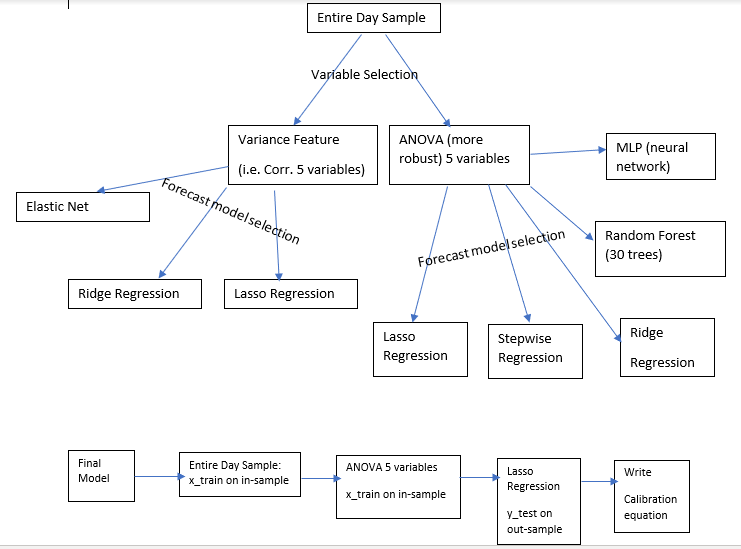

# 4.4 Project Conclusion

ANOVA feature selection was retained as best technique to underpin variables that provide significant information regarding
Y1 and Y2. Lasso regression with 2/3 train on x_train from in-sample group containing files 20220103 to 20220602 as well as 1/3  test on y_test from out-sample group containing 20220606 to 20220617 was the best model to predict Y1 and Y2. Lasso avoids overfitting by selecting features via the shrinkage of coefficients towards zero.

The calibration for Y1 is $ Y_{1} = 0.04874X_{114}$.


The calibration for Y2 is $ Y_{2} = 0.09683X_{123} + 0.14633X_{125} - 0.14645X_{128}$.

Results can vary depending on the data window selected, the feature selection technique as well as the prediction model used.
The metadata is high-dimensional with little correlation between dependent variables and target variables. 

# THE END!